In [35]:
# General
import xarray as xr    # handles netcdf data
import numpy as np     # numerical functions etc
import pandas as pd    # dataframes
import matplotlib      # plotting functions
import matplotlib.pyplot as plt    # specific plotting function I use a lot   
from matplotlib.patches import Rectangle     # specific plotting function with an annoyingly long name
import matplotlib.gridspec as gridspec #to define the sizes of plots specifically
import geopandas as gpd    # shapefiles
import cartopy     # plotting geographical features
from shapely.geometry import MultiPolygon, Polygon #to deal with 3D polygons
import regionmask    # convert shapefile to binary 0,1 mask
import re     # regular expressions (replace substrings etc)
from geopy.geocoders import Nominatim    # get lat & lon coordinates from a place name

#for climate indices
import xclim.indices as xc_i
import xclim as xc

#For plotting
import matplotlib.ticker as plticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import nc_time_axis #to plot cf.time axis
import cftime #to plot cf.time axis

#For Statistics
import scipy.stats as stats
from scipy import optimize
from xclim.indices.stats import fit
from scipy.stats import norm, gamma
import lmoments3.distr                     # conda activate xclim; pip install git+https://github.com/OpenHydrology/lmoments3.git
glo = getattr(lmoments3.distr, "glo")

#For copulas
import sklarpy.univariate as sk_uni
from sklarpy.copulas import gh_copula
from sklarpy.multivariate import mvt_normal
from sklarpy.copulas import MarginalFitter
from sklarpy.univariate import UnivariateFitter
from sklarpy import print_full
from sklarpy.copulas import gumbel_copula
from sklarpy.copulas import frank_copula
from sklarpy.copulas import clayton_copula

#For handling errors
import sys
import warnings

## Necessary Functions:

In [36]:
def get_nSPEI_calHistoric(eff_pr, eff_cal, months = range(1,13), calibration_period = slice("1980", "2010")):
    '''
    Summary:
    -----------
    Computes a the monthly SPEI value. 
    
    Parameters:
    -----------
    eff_pr: xarray DataArray object 
            - Effective Precipitation / Water Balance, defined via Precipitation - Potential Evapotranspiration
            - must be a DataArray with a time dimension labelled as a DateTime object
            
    eff_cal: xarray DataArray object
            - xarray containing the effective precipitation which is used for the calibration
         
    months: range object
            - describing the months of the year for which the SPEI value should be calculated
             
    calibration_period: slice object
            - describing the calibration timeperiod, needs to set for the timeperiod of eff_cal  
         
    Returns:
    ----------
    spei: xarray DataArray oject
            - The SPEI values              
    '''
    ## eff_pr must be a DataArray with a time dimension labelled as a DateTime object

    ## NB CURRENTLY NOTHING IN PLACE TO HANDLE DRY PERIODS IN THE TIME SERIES - USE WITH CAUTION!
    
    # create empty list to hold resuepr_callts
    spei_monthly = []
    # fit each calendar month in turn
    for m in months:    
        # select current calendar month
        epr_m = eff_pr.sel(time = eff_pr.time.dt.month == m)   
        epr_m_cal = eff_cal.sel(time = eff_cal.time.dt.month == m)
        # estimate parameters over calibration period (PWM seems to give more robust fit, so using xclim fit method - also applies over whole spatial array)
        epr_cal = epr_m_cal.sel(time = calibration_period).copy()
        # fit parameters for whole map (has to be done manually due to bug in xclim)
        pars = xr.apply_ufunc(lambda x : np.asarray(list(glo.lmom_fit(x.copy()).values())), epr_cal,
                              input_core_dims = [["time"]], output_core_dims = [["dparams"]], vectorize = True).assign_coords(dparams = ["k", "loc", "scale"])    
        # running without dry-month normalisation for now - check if needed for this dataset
        spei_m = xr.apply_ufunc(lambda pr, dparams : norm.ppf(glo.cdf(pr, *dparams)), epr_m, pars, 
                                input_core_dims=[["time"],["dparams"]], output_core_dims=[["time"]], vectorize = True).assign_coords(time = epr_m.time)
        # replace +ve (-ve) infinite values with finite maximum (minimum) in each grid cell
        spei_finite = xr.concat([spei_m.where(~np.isinf(spei_m)), 
                                 xr.ones_like(spei_m).where(spei_m == np.inf) * spei_m.where(spei_m < np.inf).max("time"),
                                 xr.ones_like(spei_m).where(spei_m == -np.inf) * spei_m.where(spei_m > -np.inf).min("time")], "new").sum("new").copy()
        spei_monthly.append(spei_finite) 

    # concatenate monthly fitted values, reorder & relabel
    spei = xr.concat(spei_monthly, "time").sortby("time").rename("spei")  
    # clean out existing attributes and replace with new variable description
    for k in list(spei.attrs.keys()): del spei.attrs[k]
    spei = spei.assign_attrs(notes = "Calibrated against "+str(calibration_period.start)+"-"+str(calibration_period.stop))
    spei = spei.where(~np.isnan(eff_pr)).dropna("time", "all")
    
    # Replace exactly zero values with linear interpolation as these are fit-failures (check with looking for nan values 
    #in spei_m, these get replaced with zeros in the spei_finite step and are handeled in the end)
    zero_mask = (spei == 0)
    spei_zero_filled = spei.where(~zero_mask)  # keep non-zero values as they are
    spei_interpolated = spei_zero_filled.interpolate_na(dim="time", method="linear")
    # Combine the interpolated values back into the original array, but only for positions where spei was zero
    spei = xr.where(zero_mask, spei_interpolated, spei)

    return spei

def get_SPEI_Duration_and_Severity_RunTheory(spei,threshold_drought=-0.8,threshold_minor=-1.5,threshold_combining=1):
    '''
    Summary:
    -----------
    Function which calculates the Severity-Duration pairs for a given SPEI timeseries. 
    
    Parameters:
    -----------
    spei: xarray DataArray oject
            - Timeseries containing the spei values
            
    threshold_drought: float 
            - Threshold representing the onset of a drought event
         
    threshold_minor: float 
            - Threshold representing the minium spei value for a 1-month event to be considered a drought
    
    threshold_combining: float 
            - Threshold representing the minium spei value which needs to be exceeded that two drought events which
            are separated by only one month to be considered individual events
         
    Returns:
    ----------
    Duration: Array
            - Values representing the Duration of the Drought events      
        
    Severity: Array
            - Values representing the Severity of the Drought events   
    '''
    
    #Set-up Array
    duration=[]
    severity=[]
    
    D=0
    S=0
    for t in np.arange(0,len(spei),1):
        #Drought Condition
        if spei[t]<threshold_drought:
            D=D+1
            S=S+spei[t]
            
        #To take the case into account if last value is just one month -> ongoing heatwave, 
        #only when last severity is lower than threshold_combining and severity of event larger than threshold_minor!
        elif spei[t-1]<threshold_drought and t==len(spei)-1 and spei[t]<threshold_combining and spei[t] < threshold_minor:
            D=D+1
            S=S
            
        #The condition before corrected for the last loop
        elif t!=len(spei)-1 and spei[t-1]<threshold_drought and spei[t+1]<threshold_drought and spei[t]<threshold_combining:
            D=D+1
            S=S
        
        #If the spei value is above the threshold and none of the conditions above apply that drought event is over
        else:
            duration.append(D )
            D=0
            severity.append(S)
            S=0

    #to get values if the drought ends in the loop
    duration.append(D)
    severity.append(S)
    
    #remove all durations of 1 if Severity is less than threshold (here set to: -1.5) 
    for i in np.arange(0,len(duration),1):
        if duration[i] == 1:
            if severity[i] > threshold_minor:
                duration[i] = 0
                severity[i] = 0
                
    #Remove all 0 and define severity positive
    duration = np.array(duration)
    duration = duration[duration>0]
    
    severity = np.array(severity)
    severity = -severity
    severity = severity[severity>0]      
    
    return duration, severity

## Load in the Data

In [51]:
#This line should point to the directory of the CMIP6 data
#Needs to be run for all 8 models in the following array:
model_array =['ACCESS-CM2','ACCESS-ESM1-5','CanESM5','FGOALS-g3','IPSL-CM6A-LR','MIROC6','MRI-ESM2-0','NorESM2-LM'] 
model_array_name = 'ACCESS-CM2'

dir_data = '/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/CMIP6/' + model_array_name + '/'
model_name = model_array_name

In [52]:
loaded_eff_eval = True #Place False to save the effective precipitation to evaluate the model
loaded_spei = True #Place False to calculate and save the SPEI for the histnat, historic, ssp245 and ssp585 scenario

### histnat,historical,ssp245,ssp585

In [39]:
if loaded_spei == False:
    #histnat
    #Tas
    fn_tas_histnat1850_2020 = dir_data + 'model_data/tas/tas_day_' + model_name + '_hist-nat*'
    ds_tas_histnat=xr.open_mfdataset(fn_tas_histnat1850_2020)
    ds_tas_histnat = ds_tas_histnat.tas

    #Tasmin
    fn_tasmin_histnat1850_2020 = dir_data + 'model_data/tasmin/tasmin_day_' + model_name + '_hist-nat*'
    ds_tasmin_histnat=xr.open_mfdataset(fn_tasmin_histnat1850_2020)
    ds_tasmin_histnat = ds_tasmin_histnat.tasmin

    #Tasmax
    fn_tasmax_histnat1850_2020 = dir_data + 'model_data/tasmax/tasmax_day_' + model_name + '_hist-nat*'
    ds_tasmax_histnat=xr.open_mfdataset(fn_tasmax_histnat1850_2020)
    ds_tasmax_histnat = ds_tasmax_histnat.tasmax

    #Precip
    fn_pr_histnat1850_2020 = dir_data + 'model_data/pr/pr_day_' + model_name + '_hist-nat*'
    ds_pr_histnat=xr.open_mfdataset(fn_pr_histnat1850_2020)
    ds_pr_histnat = ds_pr_histnat.pr

In [40]:
if loaded_spei == False:
    #historic
    #Tas
    fn_tas_historic1850_2014 = dir_data + 'model_data/tas/tas_day_' + model_name + '_historical*'
    ds_tas_historic = xr.open_mfdataset(fn_tas_historic1850_2014)
    ds_tas_historic = ds_tas_historic.tas

    #Tasmin
    fn_tasmin_historic1850_2014 = dir_data + 'model_data/tasmin/tasmin_day_' + model_name + '_historical*'
    ds_tasmin_historic = xr.open_mfdataset(fn_tasmin_historic1850_2014)
    ds_tasmin_historic = ds_tasmin_historic.tasmin

    #Tasmax
    fn_tasmax_historic1850_2014 = dir_data + 'model_data/tasmax/tasmax_day_' + model_name + '_historical*'
    ds_tasmax_historic = xr.open_mfdataset(fn_tasmax_historic1850_2014)
    ds_tasmax_historic = ds_tasmax_historic.tasmax

    #Precip
    fn_pr_historic1850_2014 = dir_data + 'model_data/pr/pr_day_' + model_name + '_historical*'
    ds_pr_historic = xr.open_mfdataset(fn_pr_historic1850_2014)
    ds_pr_historic = ds_pr_historic.pr

In [41]:
if loaded_spei == False:
    #ssp245
    #Tas
    fn_tas_ssp245_2015_2100 = dir_data + 'model_data/tas/tas_day_' + model_name + '_ssp245*'
    ds_tas_ssp245 = xr.open_mfdataset(fn_tas_ssp245_2015_2100)
    ds_tas_ssp245 = ds_tas_ssp245.tas.sel(time=slice("2015","2100"))

    #Tasmin
    fn_tasmin_ssp245_2015_2100 = dir_data + 'model_data/tasmin/tasmin_day_' + model_name + '_ssp245*'
    ds_tasmin_ssp245 = xr.open_mfdataset(fn_tasmin_ssp245_2015_2100)
    ds_tasmin_ssp245 = ds_tasmin_ssp245.tasmin.sel(time=slice("2015","2100"))

    #Tasmax
    fn_tasmax_ssp245_2015_2100 = dir_data + 'model_data/tasmax/tasmax_day_' + model_name + '_ssp245*'
    ds_tasmax_ssp245 = xr.open_mfdataset(fn_tasmax_ssp245_2015_2100)
    ds_tasmax_ssp245 = ds_tasmax_ssp245.tasmax.sel(time=slice("2015","2100"))

    #Precip
    fn_pr_ssp245_2015_2100 = dir_data + 'model_data/pr/pr_day_' + model_name + '_ssp245*'
    ds_pr_ssp245 = xr.open_mfdataset(fn_pr_ssp245_2015_2100)
    ds_pr_ssp245 = ds_pr_ssp245.pr.sel(time=slice("2015","2100"))

In [42]:
if loaded_spei == False:
    #ssp585
    #Tas
    fn_tas_ssp585_2015_2100 = dir_data + 'model_data/tas/tas_day_' + model_name + '_ssp585*'
    ds_tas_ssp585 = xr.open_mfdataset(fn_tas_ssp585_2015_2100)
    ds_tas_ssp585 = ds_tas_ssp585.tas.sel(time=slice("2015","2100"))

    #Tasmin
    fn_tasmin_ssp585_2015_2100 = dir_data + 'model_data/tasmin/tasmin_day_' + model_name + '_ssp585*'
    ds_tasmin_ssp585 = xr.open_mfdataset(fn_tasmin_ssp585_2015_2100)
    ds_tasmin_ssp585 = ds_tasmin_ssp585.tasmin.sel(time=slice("2015","2100"))

    #Tasmax
    fn_tasmax_ssp585_2015_2100 = dir_data + 'model_data/tasmax/tasmax_day_' + model_name + '_ssp585*'
    ds_tasmax_ssp585 = xr.open_mfdataset(fn_tasmax_ssp585_2015_2100)
    ds_tasmax_ssp585 = ds_tasmax_ssp585.tasmax.sel(time=slice("2015","2100"))

    #Precip
    fn_pr_ssp585_2015_2100 = dir_data + 'model_data/pr/pr_day_' + model_name + '_ssp585*'
    ds_pr_ssp585 = xr.open_mfdataset(fn_pr_ssp585_2015_2100)
    ds_pr_ssp585 = ds_pr_ssp585.pr.sel(time=slice("2015","2100"))

### Calc potential evapotranspiration

In [43]:
if loaded_spei == False:
    #Note: Use of Unit conversion: 1 kg m-2 s-1 = 86400 mm day-1
    pet_HG85_histnat = xc_i.potential_evapotranspiration(tasmin=ds_tasmin_histnat,tasmax=ds_tasmax_histnat,tas=ds_tas_histnat,method='HG85')
    pet_HG85_histnat.attrs['units'] = 'mm/day'
    eff_precip_HG85_histnat = (ds_pr_histnat-pet_HG85_histnat)*86400
    eff_precip_HG85_histnat.attrs['units'] = 'mm/day'
    #only take the land area into account
    land = regionmask.defined_regions.natural_earth_v5_0_0.land_50.mask(eff_precip_HG85_histnat.lon, eff_precip_HG85_histnat.lat)
    eff_precip_land_histnat = eff_precip_HG85_histnat.where(land==0)
    eff_precip_land_histnat_M = eff_precip_land_histnat.resample(time="MS").mean(dim="time")

    pet_HG85_historic = xc_i.potential_evapotranspiration(tasmin=ds_tasmin_historic,tasmax=ds_tasmax_historic,tas=ds_tas_historic,method='HG85')
    pet_HG85_historic.attrs['units'] = 'mm/day'
    eff_precip_HG85_historic = (ds_pr_historic - pet_HG85_historic)*86400
    eff_precip_HG85_historic.attrs['units'] = 'mm/day'
    land = regionmask.defined_regions.natural_earth_v5_0_0.land_50.mask(eff_precip_HG85_historic.lon, eff_precip_HG85_historic.lat)
    eff_precip_land_historic = eff_precip_HG85_historic.where(land==0)
    eff_precip_land_historic_M = eff_precip_land_historic.resample(time="MS").mean(dim="time")

    pet_HG85_ssp245 = xc_i.potential_evapotranspiration(tasmin=ds_tasmin_ssp245,tasmax=ds_tasmax_ssp245,tas=ds_tas_ssp245,method='HG85')
    pet_HG85_ssp245.attrs['units'] = 'mm/day'
    eff_precip_HG85_ssp245 = (ds_pr_ssp245-pet_HG85_ssp245)*86400
    eff_precip_HG85_ssp245.attrs['units'] = 'mm/day'
    land = regionmask.defined_regions.natural_earth_v5_0_0.land_50.mask(eff_precip_HG85_ssp245.lon, eff_precip_HG85_ssp245.lat)
    eff_precip_land_ssp245 = eff_precip_HG85_ssp245.where(land==0)
    eff_precip_land_ssp245_M = eff_precip_land_ssp245.resample(time="MS").mean(dim="time")

    pet_HG85_ssp585 = xc_i.potential_evapotranspiration(tasmin=ds_tasmin_ssp585,tasmax=ds_tasmax_ssp585,tas=ds_tas_ssp585,method='HG85')
    pet_HG85_ssp585.attrs['units'] = 'mm/day'
    eff_precip_HG85_ssp585 = (ds_pr_ssp585 - pet_HG85_ssp585)*86400
    eff_precip_HG85_ssp585.attrs['units'] = 'mm/day'
    land = regionmask.defined_regions.natural_earth_v5_0_0.land_50.mask(eff_precip_HG85_ssp585.lon, eff_precip_HG85_ssp585.lat)
    eff_precip_land_ssp585 = eff_precip_HG85_ssp585.where(land==0)
    eff_precip_land_ssp585_M = eff_precip_land_ssp585.resample(time="MS").mean(dim="time")

### Save Evaluation files

In [44]:
#Only put loaded_eff_eval to False to load the calibration time period in a seperate directory to perform the evaluation
loaded_eff_eval = True
if loaded_eff_eval == False:
    eval_eff_precip_HG85_m = eff_precip_land_historic_m.sel(time=slice("1980","2010"))
    eval_eff_precip_HG85_m.load()
    fn_eval_eff_precip_HG85_m = dir_data + "eff_precip/eval_eff_precip_land_historic_m.nc"
    eval_eff_precip_HG85_m.to_netcdf(fn_eval_eff_precip_HG85_m) 
    
    eval_eff_precip = eff_precip_land_historic.sel(time=slice("1980","2010"))
    eval_eff_precip_mdoy = eval_eff_precip.where(rm_SA).groupby("time.dayofyear").mean(dim="time")
    eval_eff_precip_mdoy_CUT_mLL_arr = np.zeros((8,366))
    for s in np.arange(9,16):
        eval_eff_precip_mdoy_CUT = eval_eff_precip_mdoy.sel(region=s)
        weights = np.cos(np.deg2rad(eval_eff_precip_mdoy_CUT.lat))
        weights.name = "weights"
        eval_eff_precip_mdoy_CUT_w = eval_eff_precip_mdoy_CUT.weighted(weights)
        eval_eff_precip_mdoy_CUT_w_mLL = eval_eff_precip_mdoy_CUT_w.mean(("lon", "lat"))
        eval_eff_precip_mdoy_CUT_mLL_arr[s-8] = eval_eff_precip_mdoy_CUT_w_mLL.to_numpy()
        eval_eff_precip_mdoy_CUT_mLL_arr[0] = eval_eff_precip_mdoy_CUT_w_mLL.dayofyear.to_numpy()
    fn_eval_eff_precip_mdoy_CUT_mLL_arr = dir_data + "eff_precip/eval_eff_precip_historic_land_mdoy_CUT_wmLL_arr.csv"  
    np.savetxt(fn_eval_eff_precip_mdoy_CUT_mLL_arr,eval_eff_precip_mdoy_CUT_mLL_arr,delimiter=";")

### Define Aggregation Time

In [45]:
if loaded_spei == False:
    #Calculate the different aggregation times
    eff_precip_land_histnat_M6 = eff_precip_land_histnat_M.rolling(time=6).mean()
    eff_precip_land_historic_M6 = eff_precip_land_historic_M.rolling(time=6).mean()
    eff_precip_land_ssp245_M6 = eff_precip_land_ssp245_M.rolling(time=6).mean()
    eff_precip_land_ssp585_M6 = eff_precip_land_ssp585_M.rolling(time=6).mean()
    
    eff_precip_land_histnat_M12 = eff_precip_land_histnat_M.rolling(time=12).mean()
    eff_precip_land_historic_M12 = eff_precip_land_historic_M.rolling(time=12).mean()
    eff_precip_land_ssp245_M12 = eff_precip_land_ssp245_M.rolling(time=12).mean()
    eff_precip_land_ssp585_M12 = eff_precip_land_ssp585_M.rolling(time=12).mean()
    
    #define which effective precipitation value shoud be used
    eff_precip_land_histnat = eff_precip_land_histnat_M
    eff_precip_land_historic = eff_precip_land_historic_M
    eff_precip_land_ssp245 = eff_precip_land_ssp245_M
    eff_precip_land_ssp585 = eff_precip_land_ssp585_M

In [46]:
#Change to 1, 6 or 12 according to which eff_precip is used
spei_M_str = str(1)

### Load Regions

In [50]:
#This line should refer to the directory of the IPCC AR6 region shapefiles
sf_all = gpd.read_file("/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/shapefile").to_crs(cartopy.crs.PlateCarree())
sf_SA = sf_all[sf_all['Acronym'].str.contains("NWS|NSA|NES|SAM|SWS|SES|SSA")]

fn_load_long_lat =  dir_data + 'model_data/pr/pr_day_' + model_name + '_ssp585*'
load_long_lat_raw = xr.open_mfdataset(fn_load_long_lat)
load_long_lat = load_long_lat_raw.pr

rm_SA = regionmask.mask_3D_geopandas(sf_SA, load_long_lat.lon, load_long_lat.lat).squeeze(drop = True)
sf_9 = sf_all[sf_all['Acronym'].str.contains("NWS")]
rm_9 = regionmask.mask_3D_geopandas(sf_9, load_long_lat.lon, load_long_lat.lat).squeeze(drop = True)
sf_10 = sf_all[sf_all['Acronym'].str.contains("NSA")]
rm_10 = regionmask.mask_3D_geopandas(sf_10, load_long_lat.lon, load_long_lat.lat).squeeze(drop = True)
sf_11 = sf_all[sf_all['Acronym'].str.contains("NES")]
rm_11 = regionmask.mask_3D_geopandas(sf_11, load_long_lat.lon, load_long_lat.lat).squeeze(drop = True)
sf_12 = sf_all[sf_all['Acronym'].str.contains("SAM")]
rm_12 = regionmask.mask_3D_geopandas(sf_12, load_long_lat.lon, load_long_lat.lat).squeeze(drop = True)
sf_13 = sf_all[sf_all['Acronym'].str.contains("SWS")]
rm_13 = regionmask.mask_3D_geopandas(sf_13, load_long_lat.lon, load_long_lat.lat).squeeze(drop = True)
sf_14 = sf_all[sf_all['Acronym'].str.contains("SES")]
rm_14 = regionmask.mask_3D_geopandas(sf_14, load_long_lat.lon, load_long_lat.lat).squeeze(drop = True)
sf_15 = sf_all[sf_all['Acronym'].str.contains("SSA")]
rm_15 = regionmask.mask_3D_geopandas(sf_15, load_long_lat.lon, load_long_lat.lat).squeeze(drop = True)

#Store in an array in order to access them in a loop
sf_shp_arr = np.array([sf_9,sf_10,sf_11,sf_12,sf_13,sf_14,sf_15])
region_shp_arr = np.array([rm_9,rm_10,rm_11,rm_12,rm_13,rm_14,rm_15])

/rds/general/user/nmerz/home/.conda/envs/thesis/lib/python3.9/site-packages/regionmask/core/mask.py:378: UserWarning: Detected overlapping regions. As of v0.11.0 these are correctly taken into account. Note, however, that a different mask is returned than with older versions of regionmask. To suppress this warning, set `overlap=True` (to restore the old, incorrect, behaviour, set `overlap=False`).
  warnings.warn(


## Calculate SPEI

In [24]:
#Prepare array to store the calibration values
historic_effpr_cal1980_2010 = [[],[],[],[],[],[],[]]

#Loop over all regions to calculate it for each region
if loaded_spei == False:
    #historic
    eff_precip_SA = eff_precip_land_historic_m.where(rm_SA)
    for s in np.arange(9,16):
        s_str = str(s)
        eff_precip_CUT = eff_precip_SA.sel(region=s)
        weights = np.cos(np.deg2rad(eff_precip_CUT.lat))
        weights.name = "weights"
        eff_precip_CUT_weighted = eff_precip_CUT.weighted(weights)
        eff_precip_CUT_w_mLL = eff_precip_CUT_weighted.mean(("lon", "lat"))
        eff_precip_CUT_w_mLL.load()
        historic_effpr_cal1980_2010[s-9] = eff_precip_CUT_w_mLL.sel(time=slice("1980","2010"))
        spei_M1 = get_nSPEI_calHistoric(eff_precip_CUT_w_mLL, historic_effpr_cal1980_2010[s-9], calibration_period = slice("1980", "2010"))
        fn_spei_M1 = dir_data + 'nSPEI_HG85_cal1980_2010/spei_M' + spei_M_str + '_historic_' + s_str + '.nc'
        spei_M1.to_netcdf(fn_spei_M1)

In [25]:
if loaded_spei == False:
    #histnat
    eff_precip_SA = eff_precip_land_histnat_m.where(rm_SA)
    for s in np.arange(9,16):
        s_str = str(s)
        eff_precip_CUT = eff_precip_SA.sel(region=s)
        weights = np.cos(np.deg2rad(eff_precip_CUT.lat))
        weights.name = "weights"
        eff_precip_CUT_weighted = eff_precip_CUT.weighted(weights)
        eff_precip_CUT_w_mLL = eff_precip_CUT_weighted.mean(("lon", "lat"))
        eff_precip_CUT_w_mLL.load()
        spei_M1 = get_nSPEI_calHistoric(eff_precip_CUT_w_mLL, historic_effpr_cal1980_2010[s-9], calibration_period = slice("1980", "2010"))
        fn_spei_M1 = dir_data + 'nSPEI_HG85_cal1980_2010/spei_M' + spei_M_str + '_histnat_' + s_str + '.nc'
        spei_M1.to_netcdf(fn_spei_M1)

In [26]:
if loaded_spei == False:
    #ssp245
    eff_precip_SA = eff_precip_land_ssp245_m.where(rm_SA)
    for s in np.arange(9,16):
        s_str = str(s)
        eff_precip_CUT = eff_precip_SA.sel(region=s)
        weights = np.cos(np.deg2rad(eff_precip_CUT.lat))
        weights.name = "weights"
        eff_precip_CUT_weighted = eff_precip_CUT.weighted(weights)
        eff_precip_CUT_w_mLL = eff_precip_CUT_weighted.mean(("lon", "lat"))
        eff_precip_CUT_w_mLL.load()
        spei_M1 = get_nSPEI_calHistoric(eff_precip_CUT_w_mLL, historic_effpr_cal1980_2010[s-9], calibration_period = slice("1980", "2010"))
        fn_spei_M1 = dir_data + 'nSPEI_HG85_cal1980_2010/spei_M' + spei_M_str + '_ssp245_' + s_str + '.nc'
        spei_M1.to_netcdf(fn_spei_M1)

In [27]:
if loaded_spei == False:
  #ssp585
    eff_precip_SA = eff_precip_land_ssp585_m.where(rm_SA)
    for s in np.arange(9,16):
        s_str = str(s)
        eff_precip_CUT = eff_precip_SA.sel(region=s)
        weights = np.cos(np.deg2rad(eff_precip_CUT.lat))
        weights.name = "weights"
        eff_precip_CUT_weighted = eff_precip_CUT.weighted(weights)
        eff_precip_CUT_w_mLL = eff_precip_CUT_weighted.mean(("lon", "lat"))
        eff_precip_CUT_w_mLL.load()
        spei_M1 = get_nSPEI_calHistoric(eff_precip_CUT_w_mLL, historic_effpr_cal1980_2010[s-9], calibration_period = slice("1980", "2010"))
        fn_spei_M1 = dir_data + 'nSPEI_HG85_cal1980_2010/spei_M' + spei_M_str + '_ssp585_' + s_str + '.nc'
        spei_M1.to_netcdf(fn_spei_M1)  

In [62]:
loaded_spei=True
if loaded_spei == True:
    #histnat
    #This step is necessary to provide an array of the right size
    fn_len_histnat = dir_data + 'nSPEI_HG85_cal1980_2010/spei_M' + spei_M_str + '_histnat_9.nc'
    len_histnat = xr.open_dataset(fn_len_histnat)
    n_histnat = len(len_histnat.spei.to_numpy())
    spei_histnat_arr = np.zeros((7,n_histnat))
    for s in np.arange(9,16):
        s_str = str(s) 
        fn_spei_histnat = dir_data + "nSPEI_HG85_cal1980_2010/spei_M" + spei_M_str + "_histnat_" + s_str + ".nc"
        spei_histnat_raw = xr.open_dataset(fn_spei_histnat)
        spei_histnat = spei_histnat_raw.spei
        spei_histnat_arr[s-9] = spei_histnat.to_numpy()
        if s ==  15:
            time_spei_histnat_arr = spei_histnat.time.astype("datetime64[ns]").to_numpy()
    #historic
    fn_len_historic = dir_data + 'nSPEI_HG85_cal1980_2010/spei_M' + spei_M_str + '_historic_9.nc'
    len_historic_1 = xr.open_dataset(fn_len_historic)
    len_historic = len_historic_1.where(len_historic_1['time.year'] >= 1950, drop=True)
    n_historic = len(len_historic.spei.to_numpy())
    spei_historic_arr = np.zeros((7,n_historic))
    for s in np.arange(9,16):
        s_str = str(s) 
        fn_spei_historic = dir_data + "nSPEI_HG85_cal1980_2010/spei_M" + spei_M_str + "_historic_" + s_str + ".nc"
        spei_historic_raw = xr.open_dataset(fn_spei_historic)
        spei_historic = spei_historic_raw.where(spei_historic_raw['time.year'] >= 1950, drop=True).spei
        spei_historic_arr[s-9] = spei_historic.to_numpy()
        if s ==  15:
            time_spei_historic_arr = spei_historic.time.astype("datetime64[ns]").to_numpy()
    #ssp245
    fn_len_ssp245 = dir_data + 'nSPEI_HG85_cal1980_2010/spei_M' + spei_M_str + '_ssp245_9.nc'
    len_ssp245 = xr.open_dataset(fn_len_ssp245)
    n_ssp245 = len(len_ssp245.spei.to_numpy())
    spei_ssp245_arr = np.zeros((7,n_ssp245))
    for s in np.arange(9,16):
        s_str = str(s) 
        fn_spei_ssp245 = dir_data + "nSPEI_HG85_cal1980_2010/spei_M" + spei_M_str + "_ssp245_" + s_str + ".nc"
        spei_ssp245_raw = xr.open_dataset(fn_spei_ssp245)
        spei_ssp245 = spei_ssp245_raw.spei
        spei_ssp245_arr[s-9] = spei_ssp245.to_numpy()
        if s ==  15:
            time_spei_ssp245_arr = spei_ssp245.time.astype("datetime64[ns]").to_numpy()
    #ssp585
    fn_len_ssp585 = dir_data + 'nSPEI_HG85_cal1980_2010/spei_M' + spei_M_str + '_ssp585_9.nc'
    len_ssp585 = xr.open_dataset(fn_len_ssp585)
    n_ssp585 = len(len_ssp585.spei.to_numpy())
    spei_ssp585_arr = np.zeros((7,n_ssp585))
    for s in np.arange(9,16):
        s_str = str(s) 
        fn_spei_ssp585 = dir_data + "nSPEI_HG85_cal1980_2010/spei_M" + spei_M_str + "_ssp585_" + s_str + ".nc"
        spei_ssp585_raw = xr.open_dataset(fn_spei_ssp585)
        spei_ssp585 = spei_ssp585_raw.spei
        spei_ssp585_arr[s-9] = spei_ssp585.to_numpy()
        if s ==  15:
            time_spei_ssp585_arr = spei_ssp585.time.astype("datetime64[ns]").to_numpy()

### Plot the results

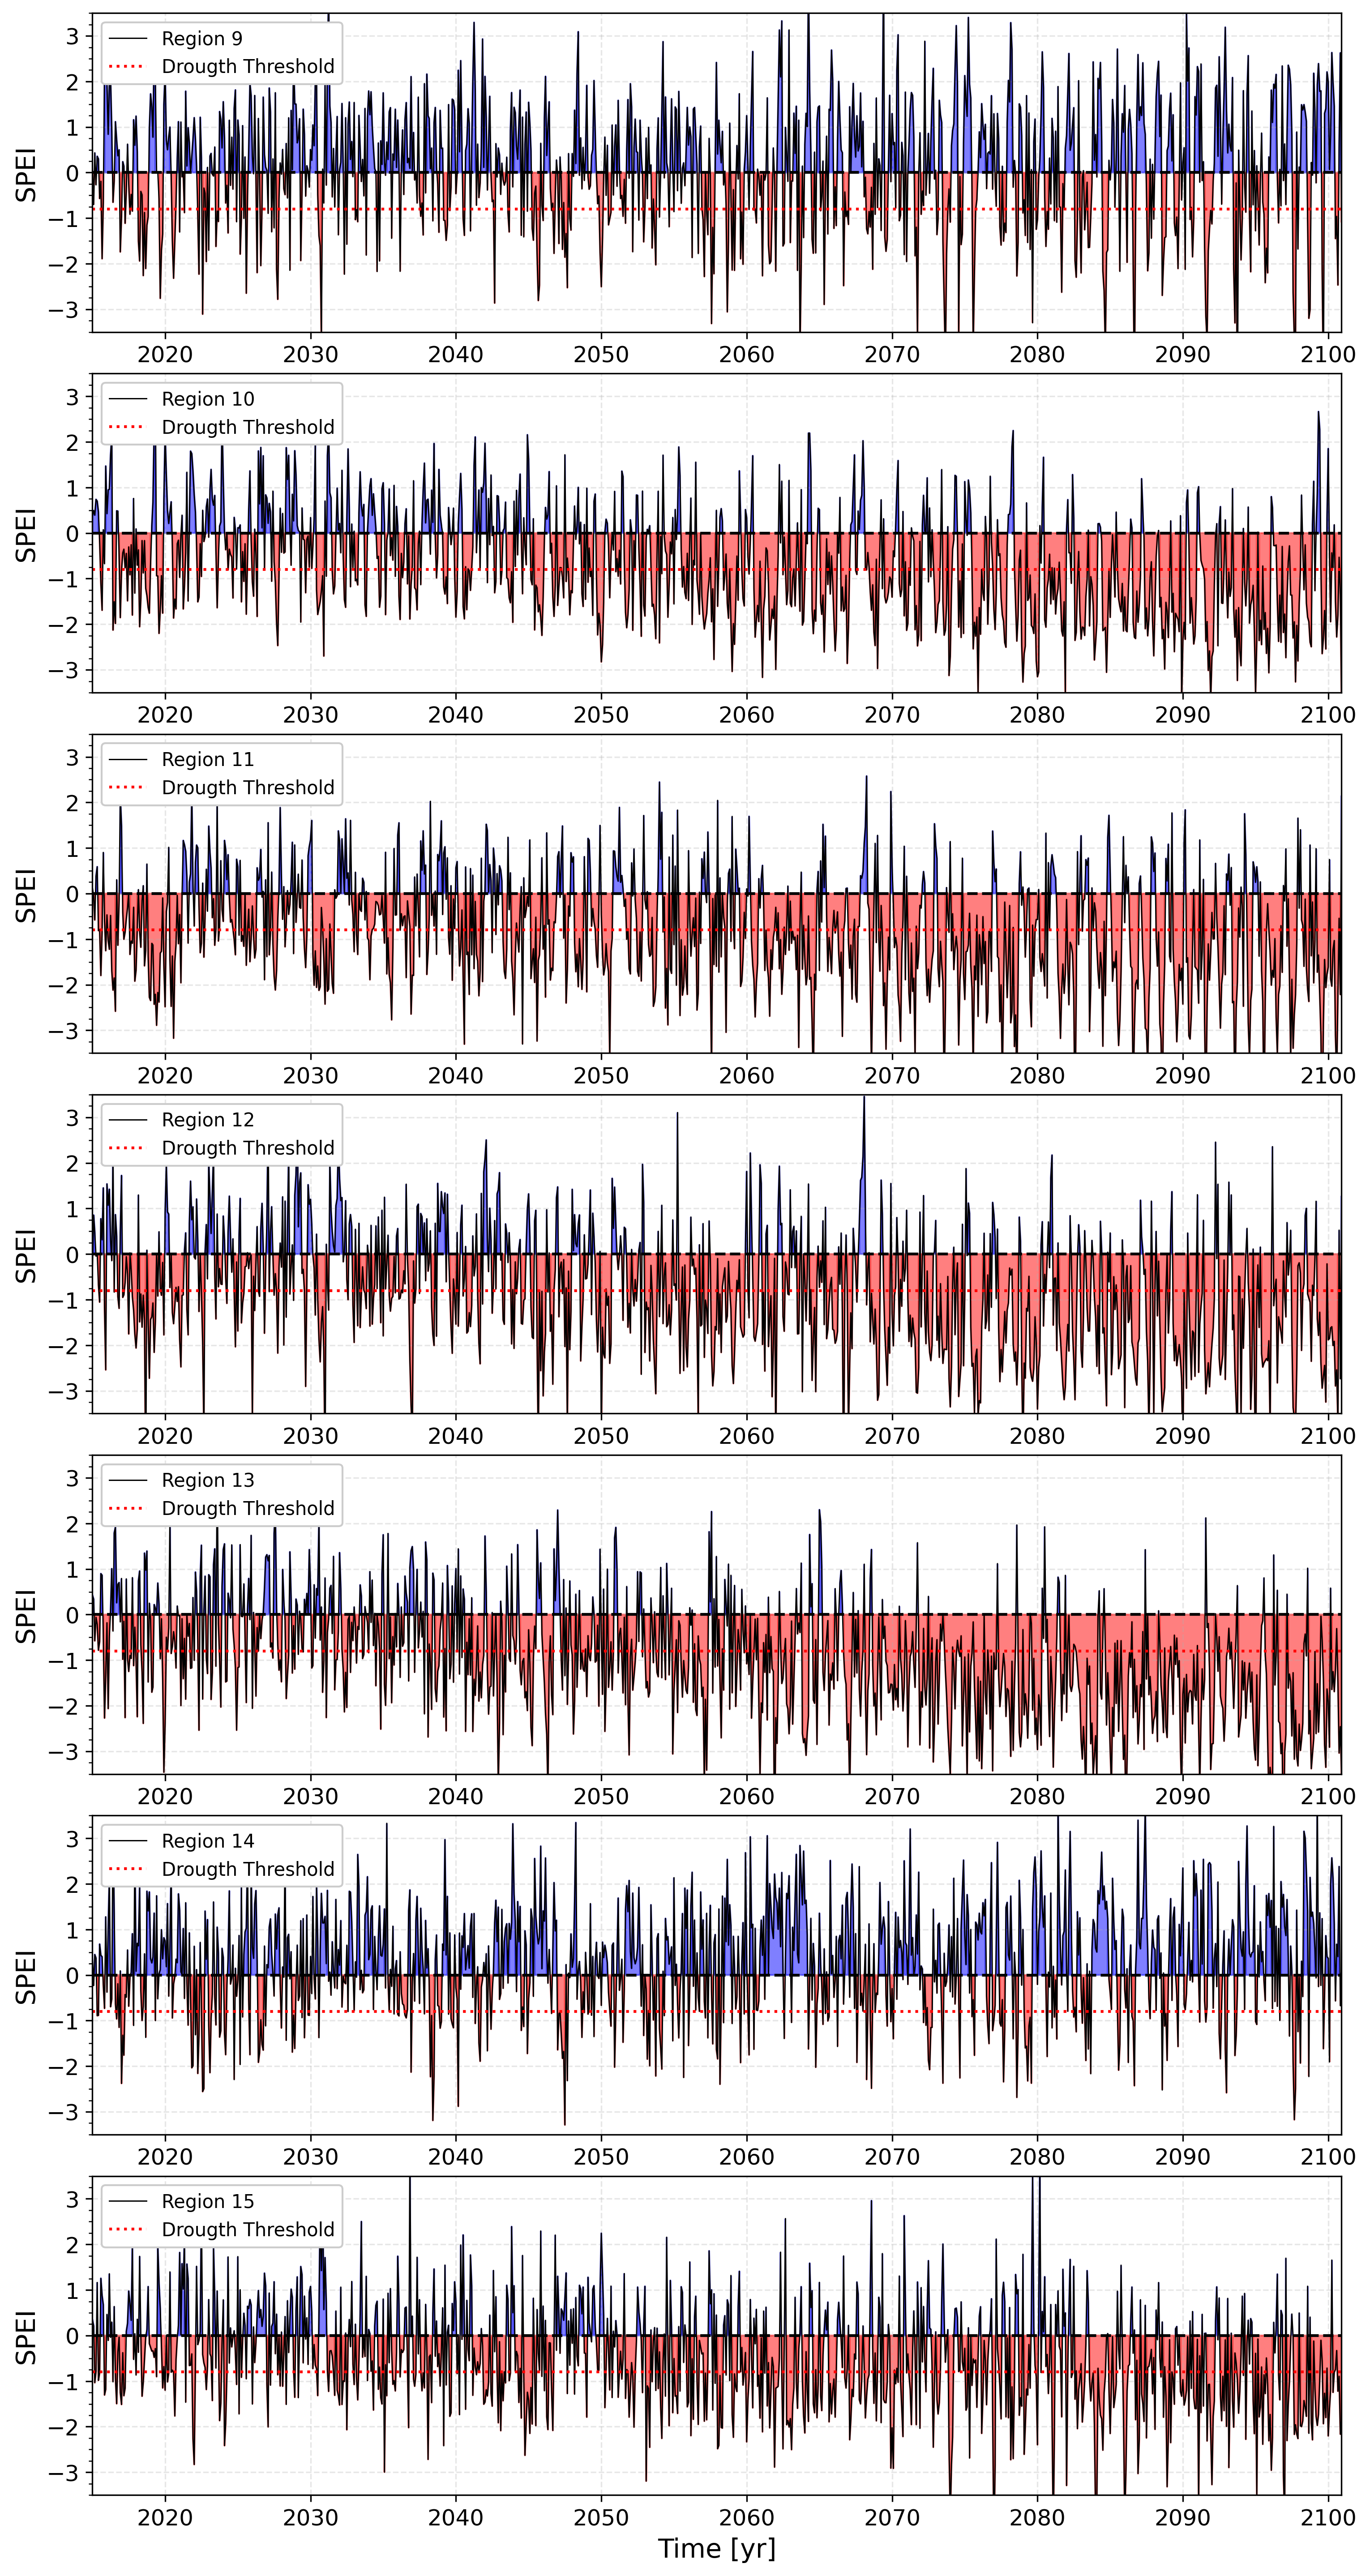

In [17]:
#Here to visualise the SPEI timeseries of the different scenarios, only used for a check
plotter_spei = True
spei = spei_ssp585_arr
time = time_spei_ssp585_arr

if plotter_spei == True:
    fig, ax = plt.subplots(ncols = 1, nrows = 7,figsize=(12,24),dpi = 300)
    fig.subplots_adjust(hspace=0.13)

    ax[0].plot(time,spei[0],label=r'Region 9', color='black',lw=0.7)
    ax[0].fill_between(time,0,spei[0],where=spei[0]>=0,color='b',alpha=0.5,interpolate=False)
    ax[0].fill_between(time,0,spei[0],where=spei[0]<=0,color='r',alpha=0.5,interpolate=False)
    ax[0].axhline(-0.8,c="red", ls="dotted",label=r'Drougth Threshold')
    ax[1].plot(time,spei[1],label=r'Region 10', color='black',lw=0.7)
    ax[1].fill_between(time,0,spei[1],where=spei[1]>=0,color='b',alpha=0.5,interpolate=False)
    ax[1].fill_between(time,0,spei[1],where=spei[1]<=0,color='r',alpha=0.5,interpolate=False)
    ax[1].axhline(-0.8,c="red", ls="dotted",label=r'Drougth Threshold')
    ax[2].plot(time,spei[2],label=r'Region 11', color='black',lw=0.7)
    ax[2].fill_between(time,0,spei[2],where=spei[2]>=0,color='b',alpha=0.5,interpolate=False)
    ax[2].fill_between(time,0,spei[2],where=spei[2]<=0,color='r',alpha=0.5,interpolate=False)
    ax[2].axhline(-0.8,c="red", ls="dotted",label=r'Drougth Threshold')
    ax[3].plot(time,spei[3],label=r'Region 12', color='black',lw=0.7)
    ax[3].fill_between(time,0,spei[3],where=spei[3]>=0,color='b',alpha=0.5,interpolate=False)
    ax[3].fill_between(time,0,spei[3],where=spei[3]<=0,color='r',alpha=0.5,interpolate=False)
    ax[3].axhline(-0.8,c="red", ls="dotted",label=r'Drougth Threshold')
    ax[4].plot(time,spei[4],label=r'Region 13', color='black',lw=0.7)
    ax[4].fill_between(time,0,spei[4],where=spei[4]>=0,color='b',alpha=0.5,interpolate=False)
    ax[4].fill_between(time,0,spei[4],where=spei[4]<=0,color='r',alpha=0.5,interpolate=False)
    ax[4].axhline(-0.8,c="red", ls="dotted",label=r'Drougth Threshold')
    ax[5].plot(time,spei[5],label=r'Region 14', color='black',lw=0.7)
    ax[5].fill_between(time,0,spei[5],where=spei[5]>=0,color='b',alpha=0.5,interpolate=False)
    ax[5].fill_between(time,0,spei[5],where=spei[5]<=0,color='r',alpha=0.5,interpolate=False)
    ax[5].axhline(-0.8,c="red", ls="dotted",label=r'Drougth Threshold')
    ax[6].plot(time,spei[6],label=r'Region 15', color='black',lw=0.7)
    ax[6].fill_between(time,0,spei[6],where=spei[6]>=0,color='b',alpha=0.5,interpolate=False)
    ax[6].fill_between(time,0,spei[6],where=spei[6]<=0,color='r',alpha=0.5,interpolate=False)
    ax[6].axhline(-0.8,c="red", ls="dotted",label=r'Drougth Threshold')

    for i in np.arange(0,7):
        ax[i].set_ylim((-3.5,3.5))
        ax[i].set_xlim((time[0], time[len(time)-1]))
        ax[i].axhline(0,c="black", ls="dashed")
        legend = ax[i].legend(loc="upper left",fontsize='10')
        legend.get_frame().set_alpha(0.5)
        legend.get_frame().set_alpha(None)
        ax[i].yaxis.set_minor_locator(MultipleLocator(0.25))# defines setting of the small ticks
        ax[i].set_xlabel(r'Time [yr]',fontsize='14')
        ax[i].set_ylabel(r'SPEI',fontsize='14')
        ax[i].tick_params(axis='both', which='major', labelsize='12')
        ax[i].grid(True,alpha=0.3,linestyle = 'dashed')

### Setting up Result Files

In [63]:
rm = regionmask.mask_3D_geopandas(sf_9, load_long_lat.lon, load_long_lat.lat).squeeze(drop = True)

sev_DA_nc_histnat_3 = spei_histnat_raw
sev_DA_nc_histnat_2 = sev_DA_nc_histnat_3.assign(sev_T100_d1=np.nan)
sev_DA_nc_histnat_1 = sev_DA_nc_histnat_2.drop_vars("spei").mean(dim="time").drop_vars("height").drop_vars("region")
sev_DA_nc_histnat = sev_DA_nc_histnat_1.where(~rm)

sev_DA_nc_historic_3 = spei_historic_raw
sev_DA_nc_historic_2 = sev_DA_nc_historic_3.assign(sev_T100_d1=np.nan)
sev_DA_nc_historic_1 = sev_DA_nc_historic_2.drop_vars("spei").mean(dim="time").drop_vars("height").drop_vars("region")
sev_DA_nc_historic = sev_DA_nc_historic_1.where(~rm)

sev_DA_nc_ssp245_3 = spei_ssp245_raw
sev_DA_nc_ssp245_2 = sev_DA_nc_ssp245_3.assign(sev_T100_d1=np.nan)
sev_DA_nc_ssp245_1 = sev_DA_nc_ssp245_2.drop_vars("spei").mean(dim="time").drop_vars("height").drop_vars("region")
sev_DA_nc_ssp245 = sev_DA_nc_ssp245_1.where(~rm)

sev_DA_nc_ssp585_3 = spei_ssp585_raw
sev_DA_nc_ssp585_2 = sev_DA_nc_ssp585_3.assign(sev_T100_d1=np.nan)
sev_DA_nc_ssp585_1 = sev_DA_nc_ssp585_2.drop_vars("spei").mean(dim="time").drop_vars("height").drop_vars("region")
sev_DA_nc_ssp585 = sev_DA_nc_ssp585_1.where(~rm)

### Saving Severity for a drought of a given return period and duration

In [64]:
# As a typical drought usually has a differet length for the different aggregation periods the length
# SDF curves needs to be adatped
if spei_M_str == "1":
    d_range = 13
elif spei_M_str == "6":
    d_range = 25
elif spei_M_str == "12":
    d_range = 37

In [65]:
lognorm = stats.lognorm
gamma = stats.gamma

#Set Parameters here!!!
dist_D_arr = np.array([lognorm,lognorm,lognorm,lognorm,lognorm,lognorm,lognorm])
dist_S_arr = np.array([lognorm,lognorm,lognorm,lognorm,lognorm,lognorm,lognorm])

plotter_individual = False #Change to True to plot all experiments individually
plotter_comparison= False #Change to True to plot comparison of experiments

#If these values are changed, change the saving names as well!!!
DA_return_T_arr = [10,50,100,500]
for T_da in np.arange(0,4,1):
    DA_return_T = DA_return_T_arr[T_da]
    for d in np.arange(1,d_range,1):
        d = int(d)
        DA_duration = d

        str_DA_name = "sev_M6_T" + str(DA_return_T) + "_D" + str(DA_duration)
        
        #Change to False to not safe the results
        save_DA = True

        region_arr = np.arange(9,16)
        region = pd.Series(region_arr, name='Region')
        dist_D = pd.Series(dist_D_arr, name='Distr_Dur')
        dist_S = pd.Series(dist_S_arr, name='Distr_Sev')
        df_dist_DS = pd.concat([region,dist_D,dist_S], axis=1)

        #histnat
        Sev_M1_T100_D1 = np.zeros(7)
        for s in np.arange(0,7):
            region_num = s + 9
            str_s = str(s)

            #Define the array for calcultion
            index = spei_histnat_arr[s]
            index_name = 'spei_histnat_arr'
            index_time = time_spei_histnat_arr

            #Calculating the duration/severity pairs
            D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)    
            Duration = pd.Series(D_spei, name='Duration')
            Severity = pd.Series(S_spei, name='Severity')
            D_S_array = pd.concat([Duration, Severity], axis=1)

            #Fitting D
            dist_D = df_dist_DS[region==region_num]["Distr_Dur"][s]
            param_D = dist_D.fit(D_S_array['Duration'],floc=0)
            if dist_D.name == 'lognorm':
                fitted_D = sk_uni.lognorm.fit(D_S_array['Duration'],param_D)
            if dist_D.name == 'gamma':
                fitted_D = sk_uni.gamma.fit(D_S_array['Duration'],param_D)
            #Fitting S
            dist_S = df_dist_DS[region==region_num]["Distr_Sev"][s]
            param_S = dist_S.fit(D_S_array['Severity'],floc=0)
            if dist_S.name == 'lognorm':
                fitted_S = sk_uni.lognorm.fit(D_S_array['Severity'],param_S)

            #define univariate Distribution
            marg_dist={0:fitted_D,1:fitted_S}

            #To prevent warnings of "overflow encountered in power"
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                fitted_copula_gumble = gumbel_copula.fit(
                    data=D_S_array, method='mle',
                    univariate_fitter_options={'significant': False}, show_progress=False,mdists=marg_dist)

            #Calculate Drought Atlas
            #Length of array
            n = len(D_S_array['Severity'])
            #Timeperiod under consideration
            diff = index_time[-1] - index_time[0] #!!!!CAREFULL HERE!!!!!
            N=diff.astype('timedelta64[Y]').astype('int')+1 #As it round offs but actually it should round up if it 29.9 years

            copula_para = fitted_copula_gumble.copula_params
            DA_r = 1 - N / (n * DA_return_T)
            DA_u1 = fitted_copula_gumble.mdists[0].cdf(DA_duration)
            def cond_gumbel(x):
                D_cdf = DA_u1
                return 1/D_cdf * np.exp(-(((-np.log(D_cdf))**copula_para.theta)+(-np.log(x))**copula_para.theta)**(1/copula_para.theta))*(1+((-np.log(x))/(-np.log(D_cdf)))**copula_para.theta)**(-1+(1/copula_para.theta))-DA_r
            V_root = optimize.root(cond_gumbel,DA_u1,method='lm').x
            v = V_root[0]
            sev_DA = fitted_copula_gumble.mdists[1].ppf(v)
        #!!!!!!!!!!! Change here if different Return time or Duration!!!!!!!!!!!
            Sev_M1_T100_D1[s] = sev_DA[0]

            sev_DA_nc_histnat = sev_DA_nc_histnat.where(~region_shp_arr[s], other=sev_DA)

        data_sev_DA = {
            'Region': ['9_NWS','10_NSA','11_NES','12_SAM','13_SWS','14_SES','15_SSA'],
            str_DA_name: Sev_M1_T100_D1
        }

        df_sev_DA_histnat = pd.DataFrame(data_sev_DA)
        #display(df_sev_DA_histnat) 

        if plotter_individual==True:
            #plot result    
            fig3, ax3 = plt.subplots(ncols = 1, nrows = 1, figsize = (10,6), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
            elev_kwargs = {"cmap" : "YlOrRd",
                           "vmin" : 2.5, 
                           "vmax" : 6}    # aim to keep 1:4 ratio to change from blue to green at zero
            sev_DA_nc_histnat.sev_T100_d1.plot(ax = ax3, **elev_kwargs, cbar_kwargs={"label": "Severity",'orientation':'vertical','shrink':0.8},robust=False,extend='both')
            glt = ax3.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', alpha=0.2, draw_labels=True)
            glt.top_labels = False
            glt.right_labels = False
            ax3.coastlines()
            ax3.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
            ax3.set_xlim([-85,-30])
            ax3.set_ylim([-60,15])
            title_str_DA = "Drought Atlast {} ({}) for return period = {} and duration = {}".format(index_name,model_name,DA_return_T,DA_duration)
            ax3.set_title(title_str_DA)
            sf_SA.boundary.plot(ax = ax3, lw = 1.5, color = "black")

        #historic
        Sev_M1_T100_D1 = np.zeros(7)
        for s in np.arange(0,7):
            region_num = s + 9
            str_s = str(s)

            #Define the array for calcultion
            index = spei_historic_arr[s]
            index_name = 'spei_historic_arr'
            index_time = time_spei_historic_arr

            #Calculating the duration/severity pairs
            D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)    
            Duration = pd.Series(D_spei, name='Duration')
            Severity = pd.Series(S_spei, name='Severity')
            D_S_array = pd.concat([Duration, Severity], axis=1)

            #Fitting D
            dist_D = df_dist_DS[region==region_num]["Distr_Dur"][s]
            param_D = dist_D.fit(D_S_array['Duration'],floc=0)
            if dist_D.name == 'lognorm':
                fitted_D = sk_uni.lognorm.fit(D_S_array['Duration'],param_D)
            if dist_D.name == 'gamma':
                fitted_D = sk_uni.gamma.fit(D_S_array['Duration'],param_D)
            #Fitting S
            dist_S = df_dist_DS[region==region_num]["Distr_Sev"][s]
            param_S = dist_S.fit(D_S_array['Severity'],floc=0)
            if dist_S.name == 'lognorm':
                fitted_S = sk_uni.lognorm.fit(D_S_array['Severity'],param_S)

            #define univariate Distribution
            marg_dist={0:fitted_D,1:fitted_S}

            #To prevent warnings of "overflow encountered in power"
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                fitted_copula_gumble = gumbel_copula.fit(
                    data=D_S_array, method='mle',
                    univariate_fitter_options={'significant': False}, show_progress=False,mdists=marg_dist)

            #Calculate Drought Atlas
            #Length of array
            n = len(D_S_array['Severity'])
            #Timeperiod under consideration
            diff = index_time[-1] - index_time[0] #!!!!CAREFULL HERE!!!!!
            N=diff.astype('timedelta64[Y]').astype('int')+1 #As it round offs but actually it should round up if it 29.9 years

            copula_para = fitted_copula_gumble.copula_params
            DA_r = 1 - N / (n * DA_return_T)
            DA_u1 = fitted_copula_gumble.mdists[0].cdf(DA_duration)
            def cond_gumbel(x):
                D_cdf = DA_u1
                return 1/D_cdf * np.exp(-(((-np.log(D_cdf))**copula_para.theta)+(-np.log(x))**copula_para.theta)**(1/copula_para.theta))*(1+((-np.log(x))/(-np.log(D_cdf)))**copula_para.theta)**(-1+(1/copula_para.theta))-DA_r
            V_root = optimize.root(cond_gumbel,DA_u1,method='lm').x
            v = V_root[0]
            sev_DA = fitted_copula_gumble.mdists[1].ppf(v)
        #!!!!!!!!!!! Change here if different Return time or Duration!!!!!!!!!!!
            Sev_M1_T100_D1[s] = sev_DA[0]

            sev_DA_nc_historic = sev_DA_nc_historic.where(~region_shp_arr[s], other=sev_DA)

        data_sev_DA = {
            'Region': ['9_NWS','10_NSA','11_NES','12_SAM','13_SWS','14_SES','15_SSA'],
            str_DA_name: Sev_M1_T100_D1
        }

        df_sev_DA_historic = pd.DataFrame(data_sev_DA)
        #display(df_sev_DA_historic)   

        if plotter_individual == True:
            #plot result    
            fig3, ax3 = plt.subplots(ncols = 1, nrows = 1, figsize = (10,6), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
            elev_kwargs = {"cmap" : "YlOrRd",
                           "vmin" : 2.5, 
                           "vmax" : 6}    # aim to keep 1:4 ratio to change from blue to green at zero
            sev_DA_nc_historic.sev_T100_d1.plot(ax = ax3, **elev_kwargs, cbar_kwargs={"label": "Severity",'orientation':'vertical','shrink':0.8},robust=False,extend='both')
            glt = ax3.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', alpha=0.2, draw_labels=True)
            glt.top_labels = False
            glt.right_labels = False
            ax3.coastlines()
            ax3.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
            ax3.set_xlim([-85,-30])
            ax3.set_ylim([-60,15])
            title_str_DA = "Drought Atlast {} ({}) for return period = {} and duration = {}".format(index_name,model_name,DA_return_T,DA_duration)
            ax3.set_title(title_str_DA)
            sf_SA.boundary.plot(ax = ax3, lw = 1.5, color = "black")

        #ssp245
        Sev_M1_T100_D1 = np.zeros(7)
        for s in np.arange(0,7):
            region_num = s + 9
            str_s = str(s)

            #Define the array for calcultion
            index = spei_ssp245_arr[s]
            index_name = 'spei_ssp245_arr'
            index_time = time_spei_ssp245_arr

            #Calculating the duration/severity pairs
            D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)    
            Duration = pd.Series(D_spei, name='Duration')
            Severity = pd.Series(S_spei, name='Severity')
            D_S_array = pd.concat([Duration, Severity], axis=1)

            #Fitting D
            dist_D = df_dist_DS[region==region_num]["Distr_Dur"][s]
            param_D = dist_D.fit(D_S_array['Duration'],floc=0)
            if dist_D.name == 'lognorm':
                fitted_D = sk_uni.lognorm.fit(D_S_array['Duration'],param_D)
            if dist_D.name == 'gamma':
                fitted_D = sk_uni.gamma.fit(D_S_array['Duration'],param_D)
            #Fitting S
            dist_S = df_dist_DS[region==region_num]["Distr_Sev"][s]
            param_S = dist_S.fit(D_S_array['Severity'],floc=0)
            if dist_S.name == 'lognorm':
                fitted_S = sk_uni.lognorm.fit(D_S_array['Severity'],param_S)

            #define univariate Distribution
            marg_dist={0:fitted_D,1:fitted_S}

            #To prevent warnings of "overflow encountered in power"
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                fitted_copula_gumble = gumbel_copula.fit(
                    data=D_S_array, method='mle',
                    univariate_fitter_options={'significant': False}, show_progress=False,mdists=marg_dist)

            #Calculate Drought Atlas
            #Length of array
            n = len(D_S_array['Severity'])
            #Timeperiod under consideration
            diff = index_time[-1] - index_time[0] #!!!!CAREFULL HERE!!!!!
            N=diff.astype('timedelta64[Y]').astype('int')+1 #As it round offs but actually it should round up if it 29.9 years

            copula_para = fitted_copula_gumble.copula_params
            DA_r = 1 - N / (n * DA_return_T)
            DA_u1 = fitted_copula_gumble.mdists[0].cdf(DA_duration)
            def cond_gumbel(x):
                D_cdf = DA_u1
                return 1/D_cdf * np.exp(-(((-np.log(D_cdf))**copula_para.theta)+(-np.log(x))**copula_para.theta)**(1/copula_para.theta))*(1+((-np.log(x))/(-np.log(D_cdf)))**copula_para.theta)**(-1+(1/copula_para.theta))-DA_r
            V_root = optimize.root(cond_gumbel,DA_u1,method='lm').x
            v = V_root[0]
            sev_DA = fitted_copula_gumble.mdists[1].ppf(v)
        #!!!!!!!!!!! Change here if different Return time or Duration!!!!!!!!!!!
            Sev_M1_T100_D1[s] = sev_DA[0]

            sev_DA_nc_ssp245 = sev_DA_nc_ssp245.where(~region_shp_arr[s], other=sev_DA)

        data_sev_DA = {
            'Region': ['9_NWS','10_NSA','11_NES','12_SAM','13_SWS','14_SES','15_SSA'],
            str_DA_name: Sev_M1_T100_D1
        }

        df_sev_DA_ssp245 = pd.DataFrame(data_sev_DA)
        #display(df_sev_DA_ssp245)   

        if plotter_individual == True:
            #plot result    
            fig3, ax3 = plt.subplots(ncols = 1, nrows = 1, figsize = (10,6), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
            elev_kwargs = {"cmap" : "YlOrRd",
                           "vmin" : 2.5, 
                           "vmax" : 6}    # aim to keep 1:4 ratio to change from blue to green at zero
            sev_DA_nc_ssp245.sev_T100_d1.plot(ax = ax3, **elev_kwargs, cbar_kwargs={"label": "Severity",'orientation':'vertical','shrink':0.8},robust=False,extend='both')
            glt = ax3.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', alpha=0.2, draw_labels=True)
            glt.top_labels = False
            glt.right_labels = False
            ax3.coastlines()
            ax3.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
            ax3.set_xlim([-85,-30])
            ax3.set_ylim([-60,15])
            title_str_DA = "Drought Atlast {} ({}) for return period = {} and duration = {}".format(index_name,model_name,DA_return_T,DA_duration)
            ax3.set_title(title_str_DA)
            sf_SA.boundary.plot(ax = ax3, lw = 1.5, color = "black")   


        #ssp585
        Sev_M1_T100_D1 = np.zeros(7)
        for s in np.arange(0,7):
            region_num = s + 9
            str_s = str(s)

            #Define the array for calcultion
            index = spei_ssp585_arr[s]
            index_name = 'spei_ssp585_arr'
            index_time = time_spei_ssp585_arr

            #Calculating the duration/severity pairs
            D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)    
            Duration = pd.Series(D_spei, name='Duration')
            Severity = pd.Series(S_spei, name='Severity')
            D_S_array = pd.concat([Duration, Severity], axis=1)

            #Fitting D
            dist_D = df_dist_DS[region==region_num]["Distr_Dur"][s]
            param_D = dist_D.fit(D_S_array['Duration'],floc=0)
            if dist_D.name == 'lognorm':
                fitted_D = sk_uni.lognorm.fit(D_S_array['Duration'],param_D)
            if dist_D.name == 'gamma':
                fitted_D = sk_uni.gamma.fit(D_S_array['Duration'],param_D)
            #Fitting S
            dist_S = df_dist_DS[region==region_num]["Distr_Sev"][s]
            param_S = dist_S.fit(D_S_array['Severity'],floc=0)
            if dist_S.name == 'lognorm':
                fitted_S = sk_uni.lognorm.fit(D_S_array['Severity'],param_S)

            #define univariate Distribution
            marg_dist={0:fitted_D,1:fitted_S}

            #To prevent warnings of "overflow encountered in power"
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                fitted_copula_gumble = gumbel_copula.fit(
                    data=D_S_array, method='mle',
                    univariate_fitter_options={'significant': False}, show_progress=False,mdists=marg_dist)

            #Calculate Drought Atlas
            #Length of array
            n = len(D_S_array['Severity'])
            #Timeperiod under consideration
            diff = index_time[-1] - index_time[0] #!!!!CAREFULL HERE!!!!!
            N=diff.astype('timedelta64[Y]').astype('int')+1 #As it round offs but actually it should round up if it 29.9 years

            copula_para = fitted_copula_gumble.copula_params
            DA_r = 1 - N / (n * DA_return_T)
            DA_u1 = fitted_copula_gumble.mdists[0].cdf(DA_duration)
            def cond_gumbel(x):
                D_cdf = DA_u1
                return 1/D_cdf * np.exp(-(((-np.log(D_cdf))**copula_para.theta)+(-np.log(x))**copula_para.theta)**(1/copula_para.theta))*(1+((-np.log(x))/(-np.log(D_cdf)))**copula_para.theta)**(-1+(1/copula_para.theta))-DA_r
            V_root = optimize.root(cond_gumbel,DA_u1,method='lm').x
            v = V_root[0]
            sev_DA = fitted_copula_gumble.mdists[1].ppf(v)
        #!!!!!!!!!!! Change here if different Return time or Duration!!!!!!!!!!!
            Sev_M1_T100_D1[s] = sev_DA[0]

            sev_DA_nc_ssp585 = sev_DA_nc_ssp585.where(~region_shp_arr[s], other=sev_DA)

        data_sev_DA = {
            'Region': ['9_NWS','10_NSA','11_NES','12_SAM','13_SWS','14_SES','15_SSA'],
            str_DA_name: Sev_M1_T100_D1
        }

        df_sev_DA_ssp585 = pd.DataFrame(data_sev_DA)
        #display(df_sev_DA_ssp585)   

        if plotter_individual == True:
            #plot result    
            fig3, ax3 = plt.subplots(ncols = 1, nrows = 1, figsize = (10,6), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
            elev_kwargs = {"cmap" : "YlOrRd",
                           "vmin" : 2.5, 
                           "vmax" : 6}    # aim to keep 1:4 ratio to change from blue to green at zero
            sev_DA_nc_ssp585.sev_T100_d1.plot(ax = ax3, **elev_kwargs, cbar_kwargs={"label": "Severity",'orientation':'vertical','shrink':0.8},robust=False,extend='both')
            glt = ax3.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', alpha=0.2, draw_labels=True)
            glt.top_labels = False
            glt.right_labels = False
            ax3.coastlines()
            ax3.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
            ax3.set_xlim([-85,-30])
            ax3.set_ylim([-60,15])
            title_str_DA = "Drought Atlast {} ({}) for return period = {} and duration = {}".format(index_name,model_name,DA_return_T,DA_duration)
            ax3.set_title(title_str_DA)
            sf_SA.boundary.plot(ax = ax3, lw = 1.5, color = "black")

        fn_sev_histnat = str_DA_name + "_histnat"
        fn_sev_historic = str_DA_name + "_historic"
        fn_sev_ssp245 = str_DA_name + "_ssp245"
        fn_sev_ssp585 = str_DA_name + "_ssp585"

        data_sev_DA_final = {
            'Region': ['9_NWS','10_NSA','11_NES','12_SAM','13_SWS','14_SES','15_SSA'],
            fn_sev_histnat: df_sev_DA_histnat[str_DA_name],
            fn_sev_historic: df_sev_DA_historic[str_DA_name],
            fn_sev_ssp245: df_sev_DA_ssp245[str_DA_name],
            fn_sev_ssp585: df_sev_DA_ssp585[str_DA_name],
        }

        df_sev_DA_final = pd.DataFrame(data_sev_DA_final)
        #display(df_sev_DA_final)
        
        #Safe the combined results
        if save_DA==True:
            fn_df_sev_DA_final = dir_data + "results_sev_given_T_D/df_" + str_DA_name + "_final.csv"
            df_sev_DA_final.to_csv(fn_df_sev_DA_final,sep=";")

        if plotter_comparison == True:
            fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (8,10), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
            #fig.subplots_adjust(hspace=0.2, wspace=0.2)
            elev_kwargs = {"cmap" : "YlOrRd",
                           "vmin" : sev_DA_nc_histnat.sev_T100_d1.min()-1, 
                           "vmax" : sev_DA_nc_ssp585.sev_T100_d1.max()+1}  
            cbar=sev_DA_nc_histnat.sev_T100_d1.plot(ax = ax[0][0], **elev_kwargs, add_colorbar=False)
            sev_DA_nc_historic.sev_T100_d1.plot(ax = ax[0][1], **elev_kwargs, add_colorbar=False)
            sev_DA_nc_ssp245.sev_T100_d1.plot(ax = ax[1][0], **elev_kwargs, add_colorbar=False)
            sev_DA_nc_ssp585.sev_T100_d1.plot(ax = ax[1][1], **elev_kwargs, add_colorbar=False)

            ticker=0
            names = np.array(["histnat","historic","ssp245","ssp585"])
            for j in np.arange(0,2):
                for i in np.arange(0,2):
                    glt = ax[j][i].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', alpha=0.2, draw_labels=True)
                    ax[j][i].coastlines()
                    ax[j][i].add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
                    ax[j][i].set_title(names[ticker], loc = "center",fontsize=14)
                    ax[j][i].set_xlim([-85,-30])
                    ax[j][i].set_ylim([-60,15])
                    glt.top_labels = False
                    glt.right_labels = False
                    sf_SA.boundary.plot(ax = ax[j][i], lw = 1.5, color = "black")
                    ticker+=1

            cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])        
            cbar = plt.colorbar(cbar, cax=cbar_ax, location = "bottom", fraction = 0.03, pad = 0.09, extend = "both")
            cbar.set_label(label = "Severity",fontsize=12)

### More Analysis

!!!!!!!!!!!!!!!!!!!!
The following code provides further insides into the analysis of the data but does not produce any important output
!!!!!!!!!!!!!!!!!!!!

### Plot SDF-comparison of histnat, historic, ssp245 and ssp585

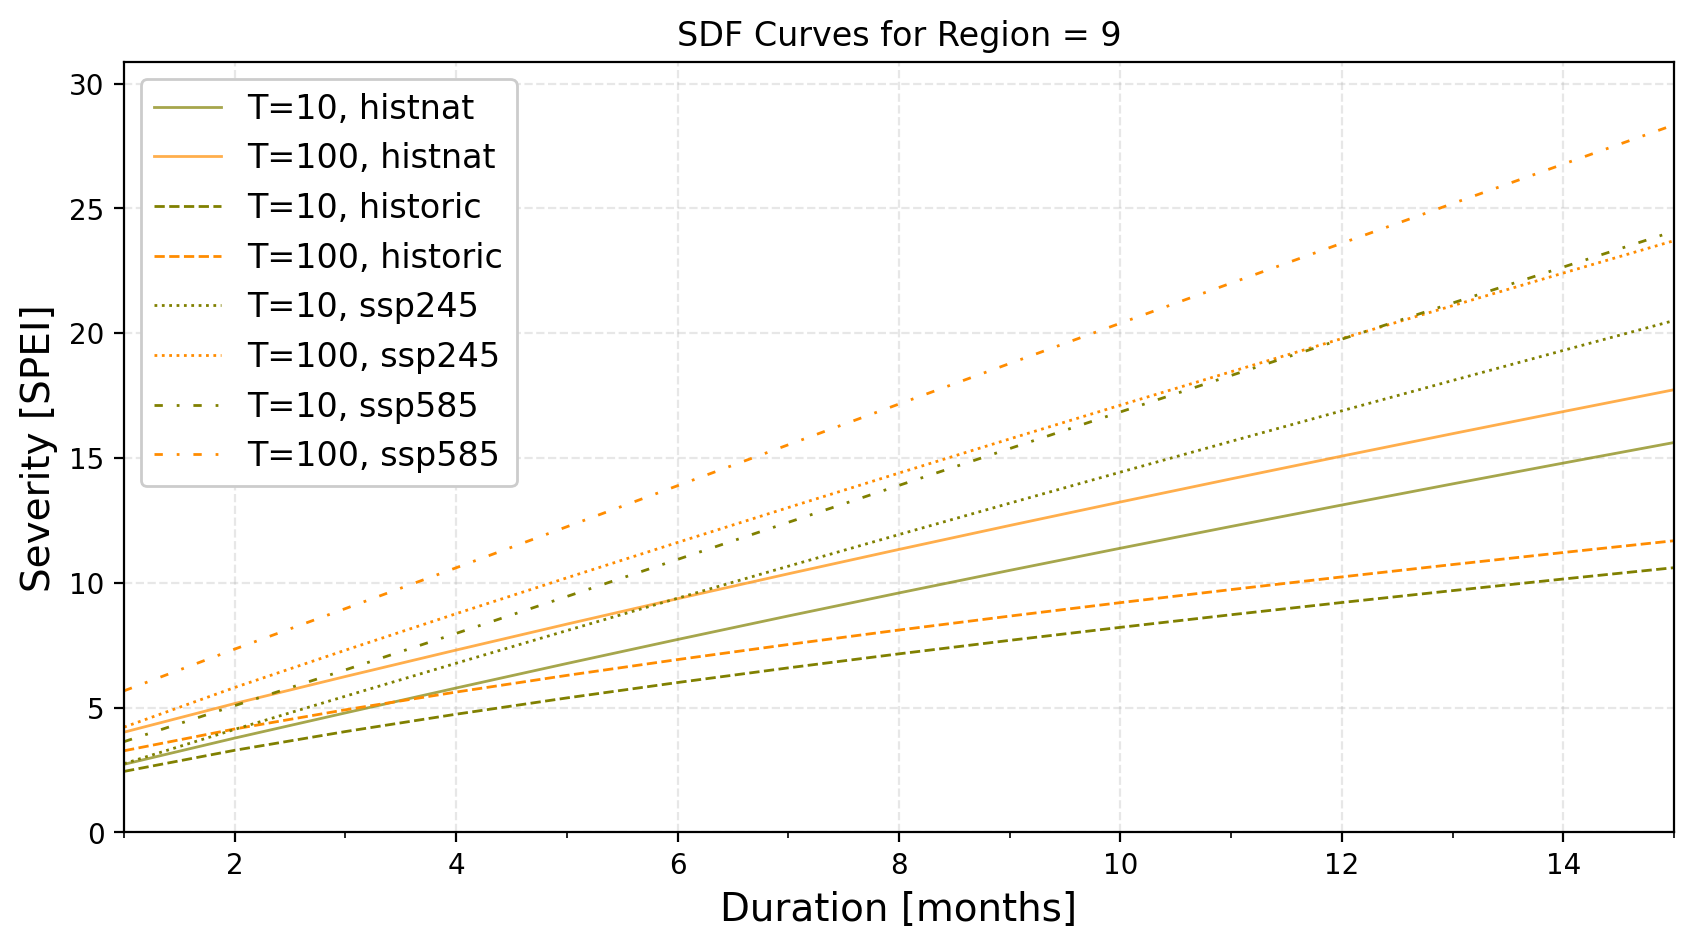

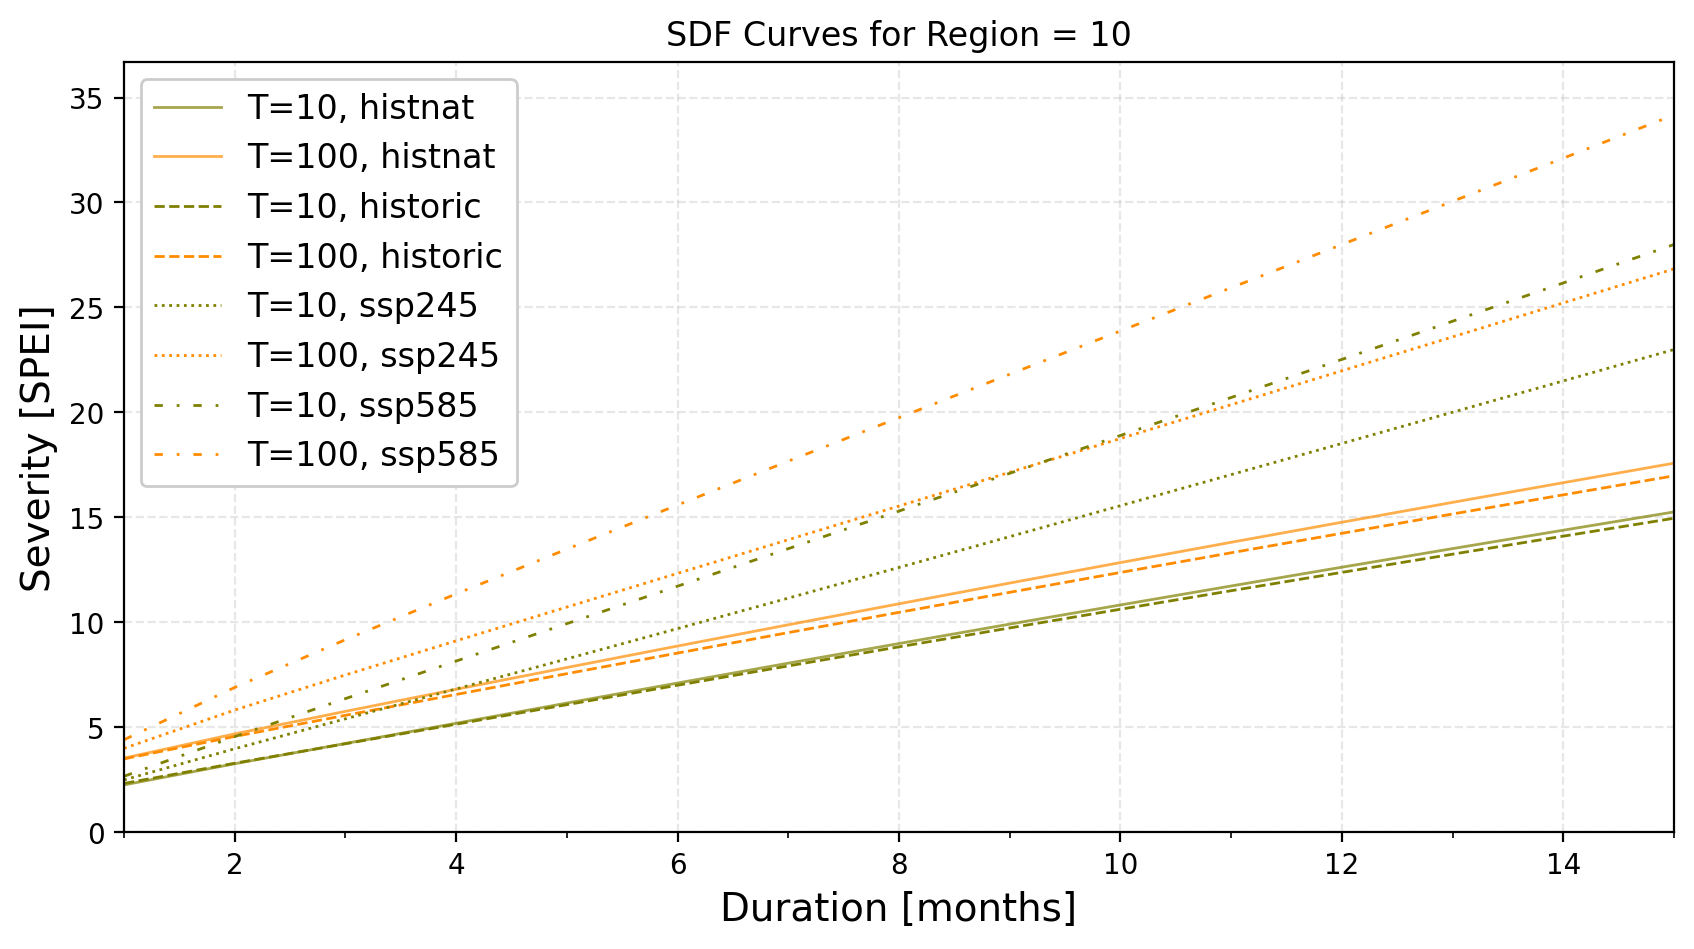

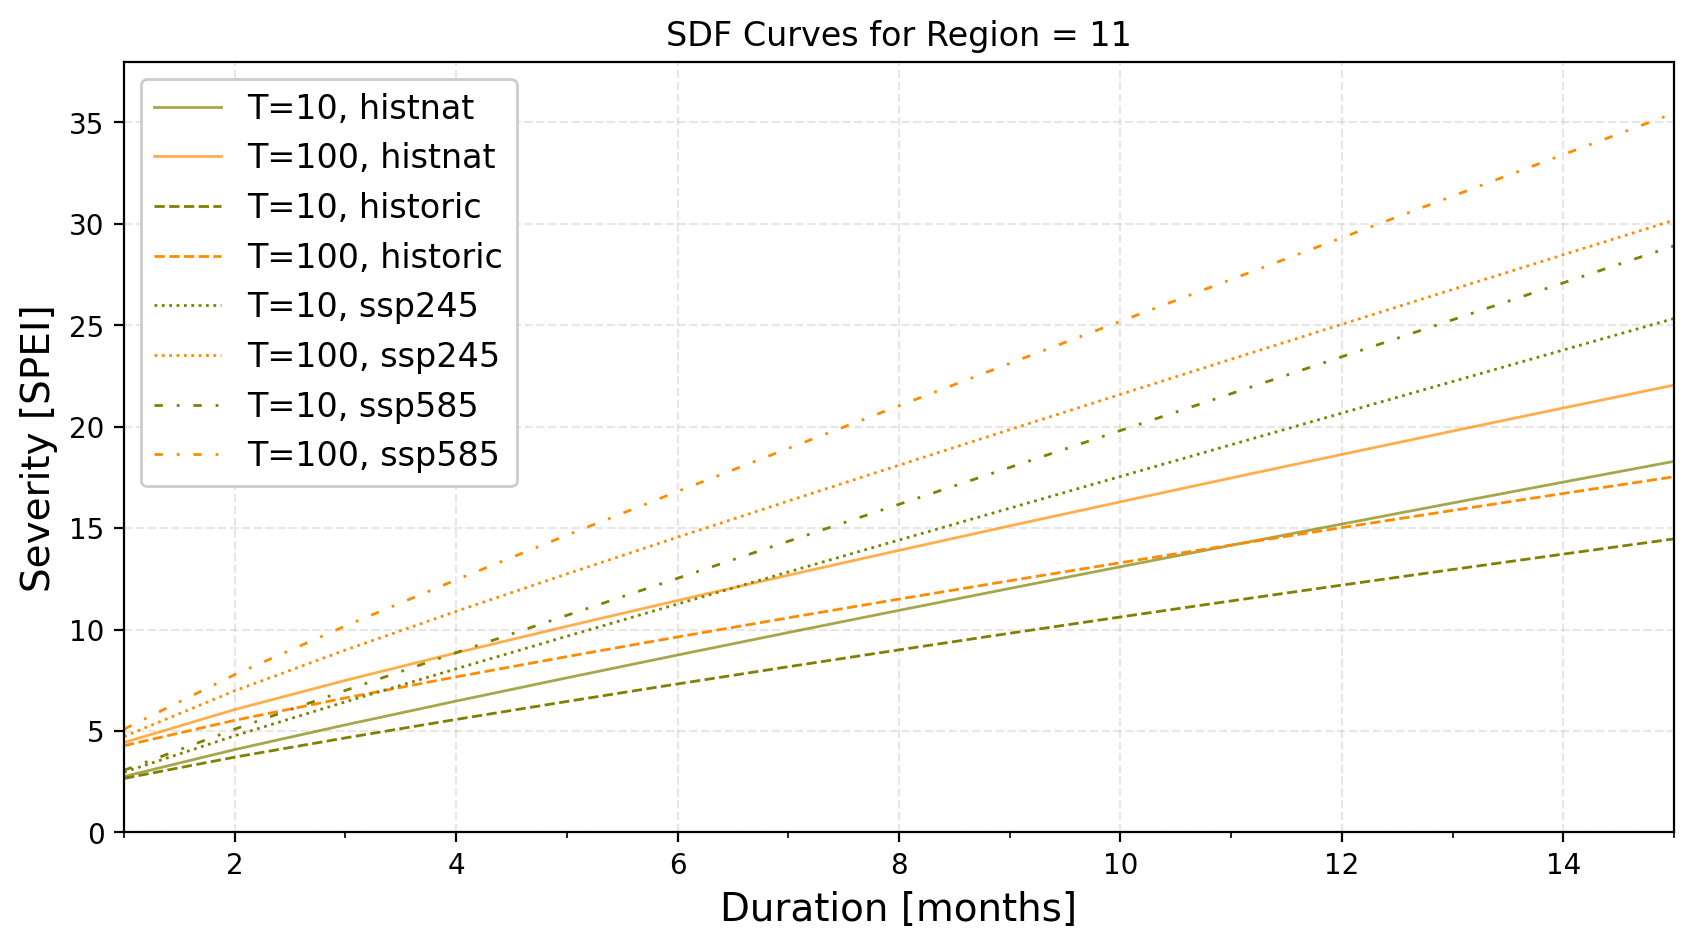

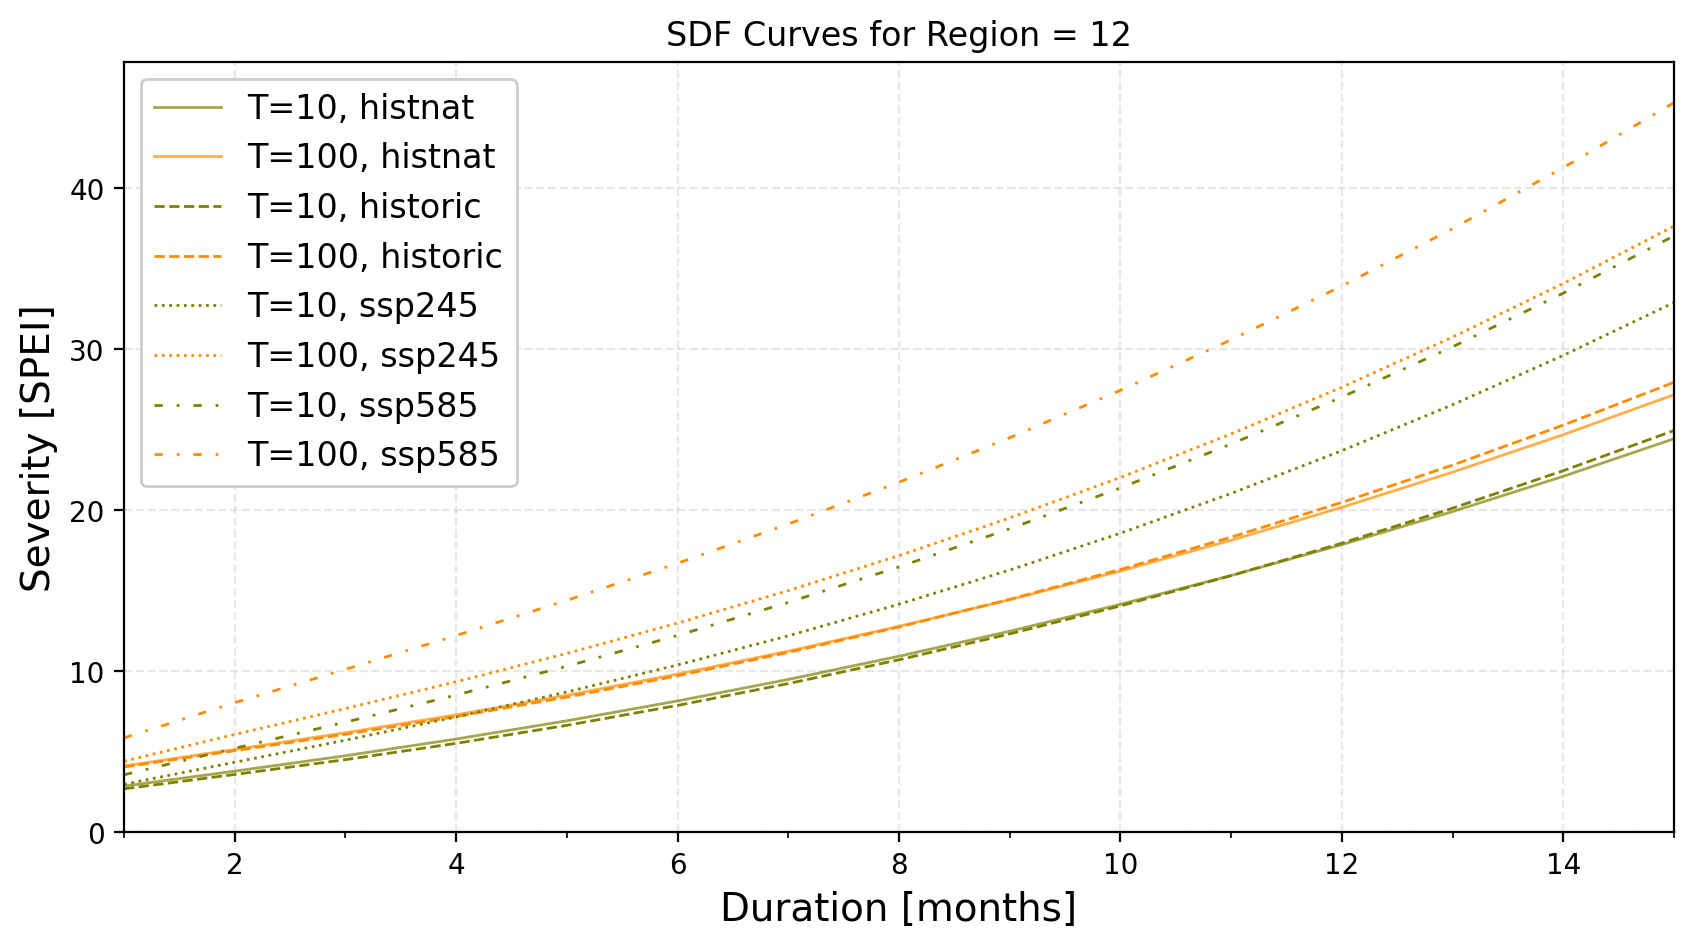

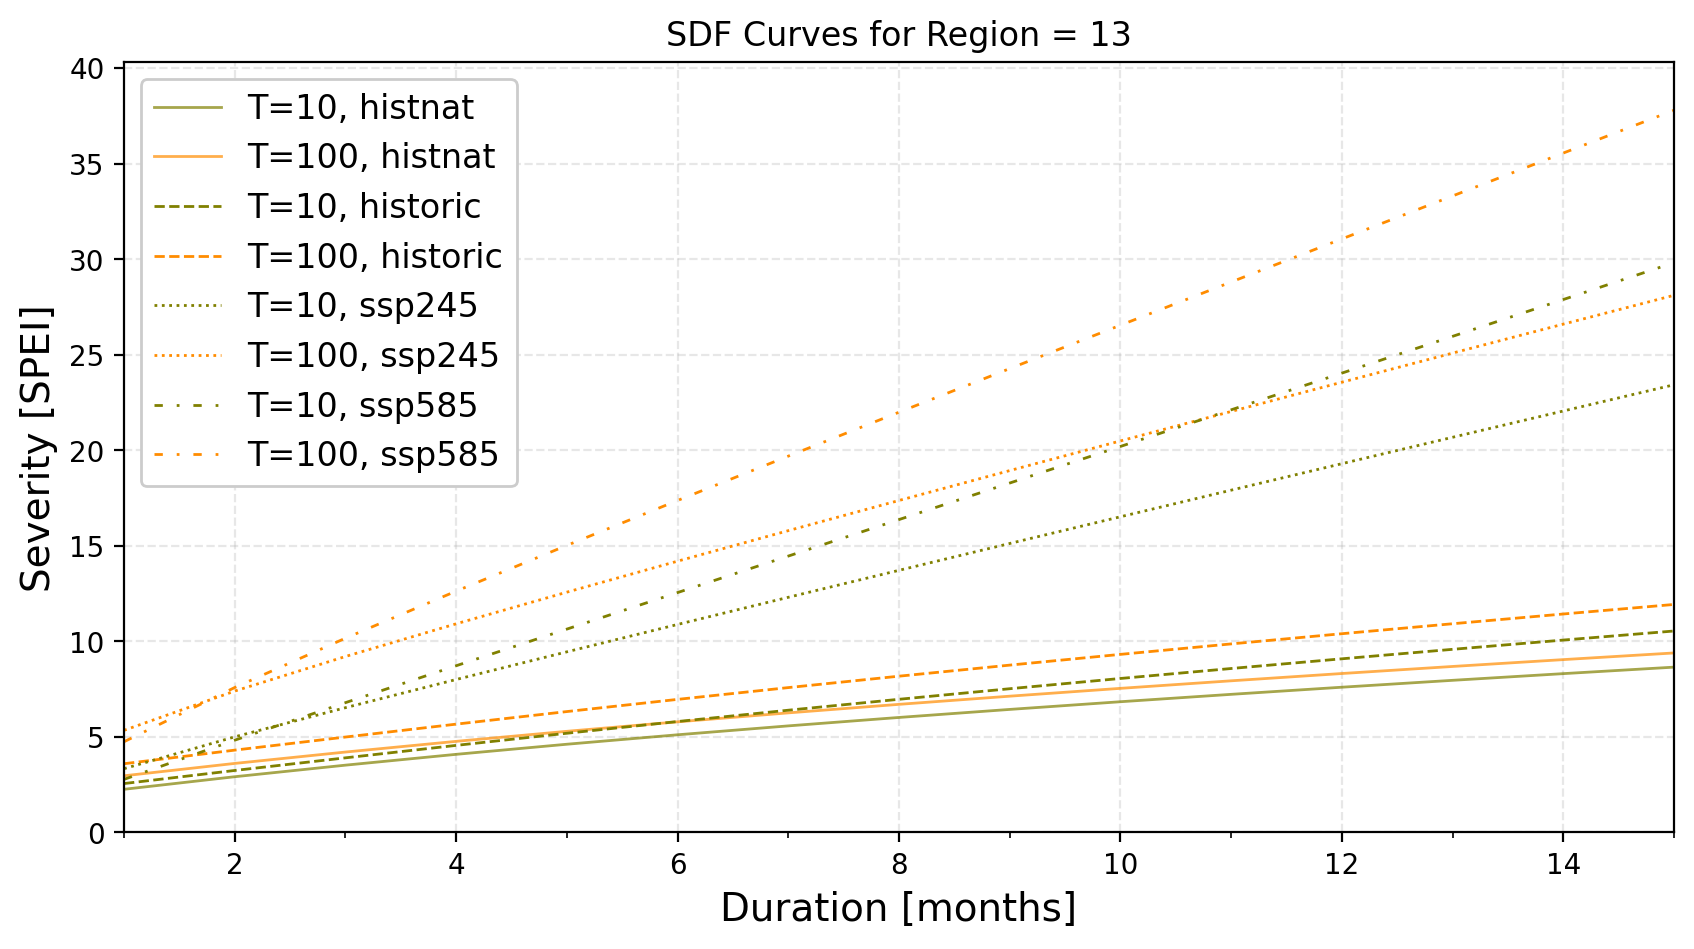

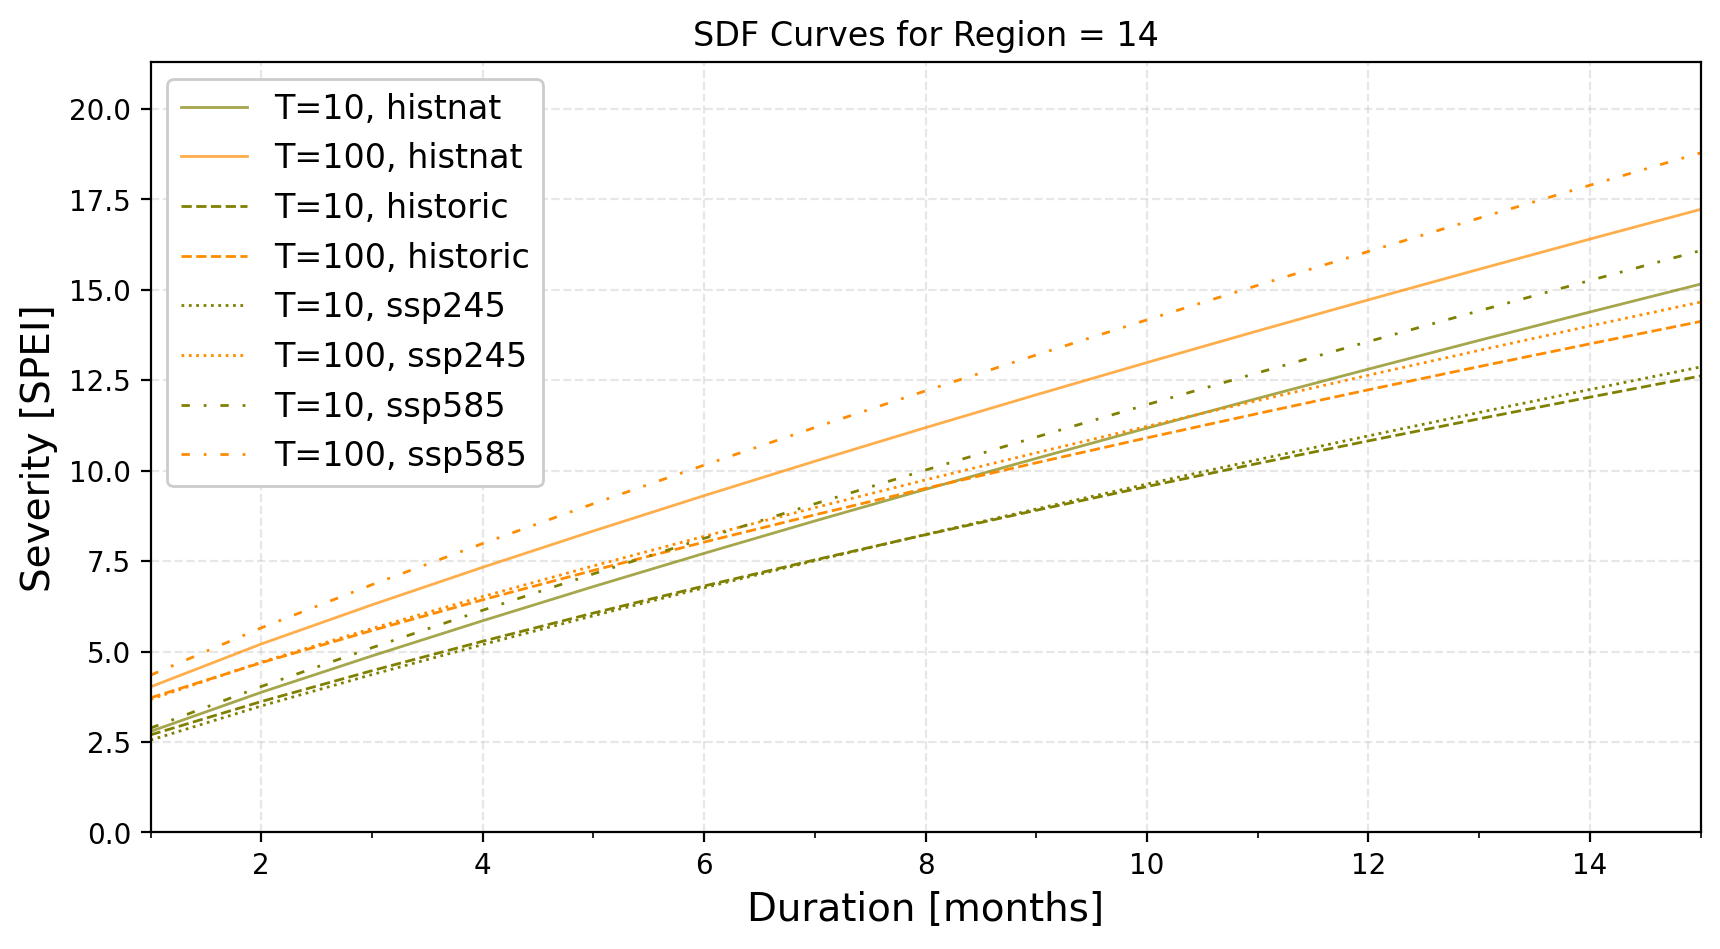

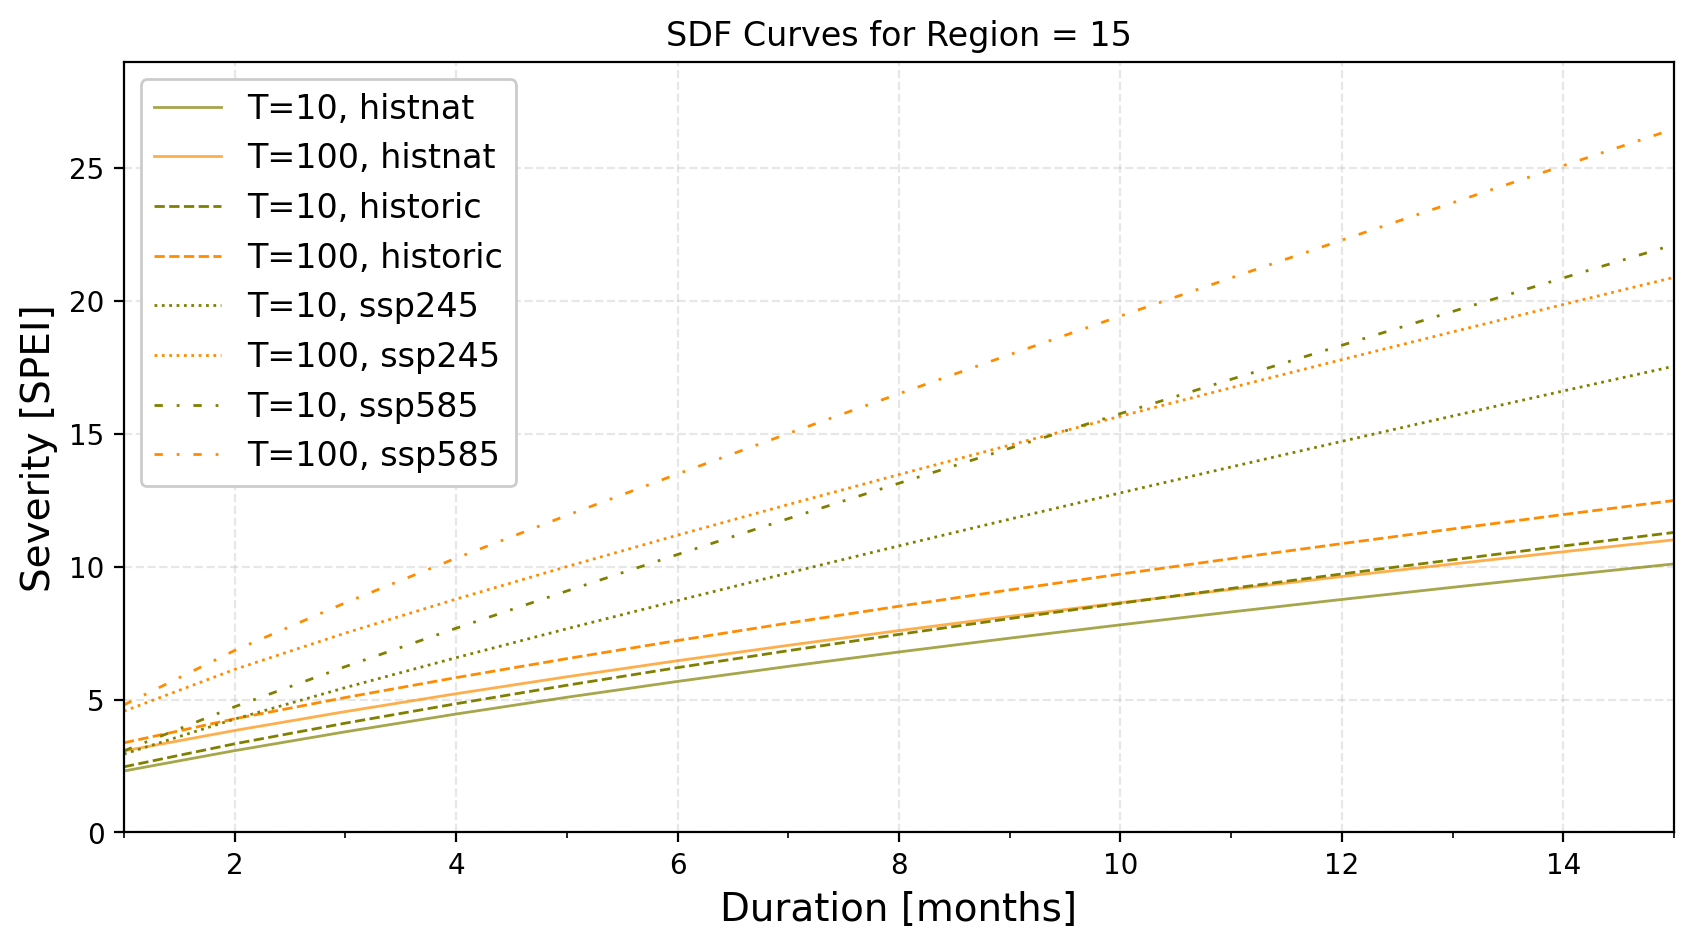

In [26]:
return_T = np.array([10,100])
#Define till which month should be plotted
dur_plot = 15

Sev_SDF_M1_histnat = np.zeros((7,len(return_T), len(np.arange(1,dur_plot+1,1))))
Sev_SDF_M1_historic = np.zeros((7,len(return_T), len(np.arange(1,dur_plot+1,1))))
Sev_SDF_M1_ssp245 = np.zeros((7,len(return_T), len(np.arange(1,dur_plot+1,1))))
Sev_SDF_M1_ssp585 = np.zeros((7,len(return_T), len(np.arange(1,dur_plot+1,1))))

simulation_spei = [spei_histnat_arr,spei_historic_arr,spei_ssp245_arr,spei_ssp585_arr]
simulation_time = [time_spei_histnat_arr,time_spei_historic_arr,time_spei_ssp245_arr,time_spei_ssp585_arr]
sim_SDF = [Sev_SDF_M1_histnat,Sev_SDF_M1_historic,Sev_SDF_M1_ssp245,Sev_SDF_M1_ssp585]

for exp in np.arange(0,4):
    spei_index = simulation_spei[exp]
    simulation_time_index = simulation_time[exp]
    for s in np.arange(0,7):
        region_num = s + 9
        str_s = str(s)

        #Define the array for calcultion
        index = spei_index[s]
        index_name = 'spei_histnat_arr'
        index_time = simulation_time_index

        #Calculating the duration/severity pairs
        D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)    
        Duration = pd.Series(D_spei, name='Duration')
        Severity = pd.Series(S_spei, name='Severity')
        D_S_array = pd.concat([Duration, Severity], axis=1)

        #Fitting D
        dist_D = df_dist_DS[region==region_num]["Distr_Dur"][s]
        param_D = dist_D.fit(D_S_array['Duration'],floc=0)
        if dist_D.name == 'lognorm':
            fitted_D = sk_uni.lognorm.fit(D_S_array['Duration'],param_D)
        if dist_D.name == 'gamma':
            fitted_D = sk_uni.gamma.fit(D_S_array['Duration'],param_D)
        #Fitting S
        dist_S = df_dist_DS[region==region_num]["Distr_Sev"][s]
        param_S = dist_S.fit(D_S_array['Severity'],floc=0)
        if dist_S.name == 'lognorm':
            fitted_S = sk_uni.lognorm.fit(D_S_array['Severity'],param_S)

        #define univariate Distribution
        marg_dist={0:fitted_D,1:fitted_S}

        #To prevent warnings of "overflow encountered in power"
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            fitted_copula_gumble = gumbel_copula.fit(
                data=D_S_array, method='mle',
                univariate_fitter_options={'significant': False}, show_progress=False,mdists=marg_dist)
        #Length of array
        n = len(D_S_array['Severity'])
        #Timeperiod under consideration
        diff = index_time[-1] - index_time[0] #!!!!CAREFULL HERE!!!!!
        N=diff.astype('timedelta64[Y]').astype('int')+1 #As it round offs but actually it should round up if it 29.9 years
        #Define till which month should be plotted +1 because of implementation
        dur_threshold = dur_plot +1
        #Set up array to safe results
        #sev_M1_histnat = sim_SDF[s]
        for T in np.arange(0,len(return_T),1):
            return_Time = return_T[T]
            #calc return
            r = 1 - N / (n * return_Time)
            #give Duration range
            dur_M1_histnat = np.arange(1,dur_threshold,1)
            #calc fitted univariate duration curve
            u1 = fitted_copula_gumble.mdists[0].cdf(dur_M1_histnat)
            #load gumble fitting parameters !!!! Change here if other Copula is used but also equation below
            copula_para = fitted_copula_gumble.copula_params
            #Create Temporay value for severity
            v = np.zeros(len(u1))
            #Solve conditional gumble equation for all duration values for severity !!!! Change here if other Copula is used
            for j in np.arange(0,len(u1),1):
                def cond_gumbel(x):
                    D_cdf = u1[j]
                    return 1/D_cdf * np.exp(-(((-np.log(D_cdf))**copula_para.theta)+(-np.log(x))**copula_para.theta)**(1/copula_para.theta))*(1+((-np.log(x))/(-np.log(D_cdf)))**copula_para.theta)**(-1+(1/copula_para.theta))-r
                #V = fsolve(cond_gumbel,u1[j]) -> uses other algorithm than Matlab...
                V_root = optimize.root(cond_gumbel,u1[j],method='lm').x
                v[j] = V_root[0]
            #get the final severity values through the inverse cdf function
            sim_SDF[exp][s][T] = fitted_copula_gumble.mdists[1].ppf(v)

for s in np.arange(0,7):
    fig, ax = plt.subplots(figsize=(10,5),dpi = 200)
    label_1 = "T={}, histnat".format(return_T[0])
    ax.plot(dur_M1_histnat, sim_SDF[0][s][0], color='olive',label=label_1,lw=1,alpha=0.7)
    label_2 = "T={}, histnat".format(return_T[1])
    ax.plot(dur_M1_histnat, sim_SDF[0][s][1], color='darkorange',label=label_2,lw=1,alpha=0.7)
    #label_3 = "T={}, histnat".format(return_T[2])
    #ax.plot(dur_M1_histnat, Sev_SDF_M1_histnat[s][2], color='red',label=label_3,lw=0.8,alpha=0.7)
    
    label_1 = "T={}, historic".format(return_T[0])
    ax.plot(dur_M1_histnat, sim_SDF[1][s][0], color='olive',label=label_1,lw=1,ls="dashed")
    #ax.plot(dur_M1_histnat, sim_SDF[1][s][0], color='darkgreen',label=label_1,lw=0.8)
    label_2 = "T={}, historic".format(return_T[1])
    ax.plot(dur_M1_histnat, sim_SDF[1][s][1], color='darkorange',label=label_2,lw=1,ls="dashed")
    #ax.plot(dur_M1_histnat, sim_SDF[1][s][1], color='#ffd343',label=label_2,lw=0.8)
    #label_3 = "T={}, historic".format(return_T[2])
    #ax.plot(dur_M1_histnat, Sev_SDF_M1_historic[s][2], color='brown',label=label_3,lw=0.8)
    
    label_1 = "T={}, ssp245".format(return_T[0])
    ax.plot(dur_M1_histnat, sim_SDF[2][s][0], color='olive',label=label_1,lw=1,ls="dotted")
    label_2 = "T={}, ssp245".format(return_T[1])
    ax.plot(dur_M1_histnat, sim_SDF[2][s][1], color='darkorange',label=label_2,lw=1,ls="dotted")
    #label_3 = "T={}, historic".format(return_T[2])
    #ax.plot(dur_M1_histnat, Sev_SDF_M1_historic[s][2], color='brown',label=label_3,lw=0.8)
    
    label_1 = "T={}, ssp585".format(return_T[0])
    ax.plot(dur_M1_histnat, sim_SDF[3][s][0], color='olive',label=label_1,lw=1,ls=(0,(3,5,1,5)))
    label_2 = "T={}, ssp585".format(return_T[1])
    ax.plot(dur_M1_histnat, sim_SDF[3][s][1], color='darkorange',label=label_2,lw=1,ls=(0,(3,5,1,5)))
    #label_3 = "T={}, historic".format(return_T[2])
    #ax.plot(dur_M1_histnat, Sev_SDF_M1_historic[s][2], color='brown',label=label_3,lw=0.8)

    ax.set_xlim(1, dur_plot)
    ax.set_ylim(0,sim_SDF[exp][s][1].max()+2.5)
    #ax.axvline(max(D_S_array['Duration']),c="black", ls="dashed")
    #ax.axhline(max(D_S_array['Severity']),c="black", ls="dashed")
    ax.xaxis.set_minor_locator(MultipleLocator(1))# defines setting of the small ticks
    #ax.yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend = plt.legend(loc="upper left",fontsize='12')
    legend.get_frame().set_alpha(0.5)
    legend.get_frame().set_alpha(None)
    title_str = "SDF Curves for Region = {}".format(s+9)
    ax.set_title(title_str)
    ax.set_xlabel(r'Duration [months]',fontsize='14')
    ax.set_ylabel(r'Severity [SPEI]',fontsize='14')
    ax.tick_params(axis='both', which='major', labelsize='10')
    ax.grid(True,alpha=0.3,linestyle = 'dashed')

### Test specific region

In [29]:
sev_DA_nc_3 = spei_histnat_raw
sev_DA_nc_2 = sev_DA_nc_3.assign(sev_T100_d1=np.nan)
sev_DA_nc_1 = sev_DA_nc_2.drop_vars("spei").mean(dim="time").drop_vars("height").drop_vars("region")
sev_DA_nc = sev_DA_nc_1.where(~rm)

number of pairs 50
PearsonR Duration and Severity: PearsonRResult(statistic=0.9567588949652368, pvalue=2.1670763131252355e-27)
Duration Fit:


Distribution  AIC_normal  AIC_adapted  MSE_adapted  KS_pValue  KS_Distance
0        Expon  237.066718  -232.024576     0.009274   0.000002     0.364369
1        Gamma  210.470019  -196.385911     0.018175   0.131526     0.161541
2      LogNorm  202.910580  -210.433071     0.013723   0.235104     0.142952
3      Weibull  219.856728  -202.890190     0.015958   0.025650     0.204874

-----> best fit according to AIC_normal: LogNorm
Severity Fit:


Distribution  AIC_normal  AIC_adapted  MSE_adapted  KS_pValue  KS_Distance
0        Expon  253.379501  -191.603541     0.020815   0.000087     0.310787
1        Gamma  226.062426  -276.225424     0.003681   0.422950     0.121048
2      LogNorm  216.735080  -314.036353     0.001728   0.604113     0.104870
3      Weibull  236.134635  -252.180667     0.005954   0.193697     0.149418

-----> best fit according to AIC_normal: LogNorm


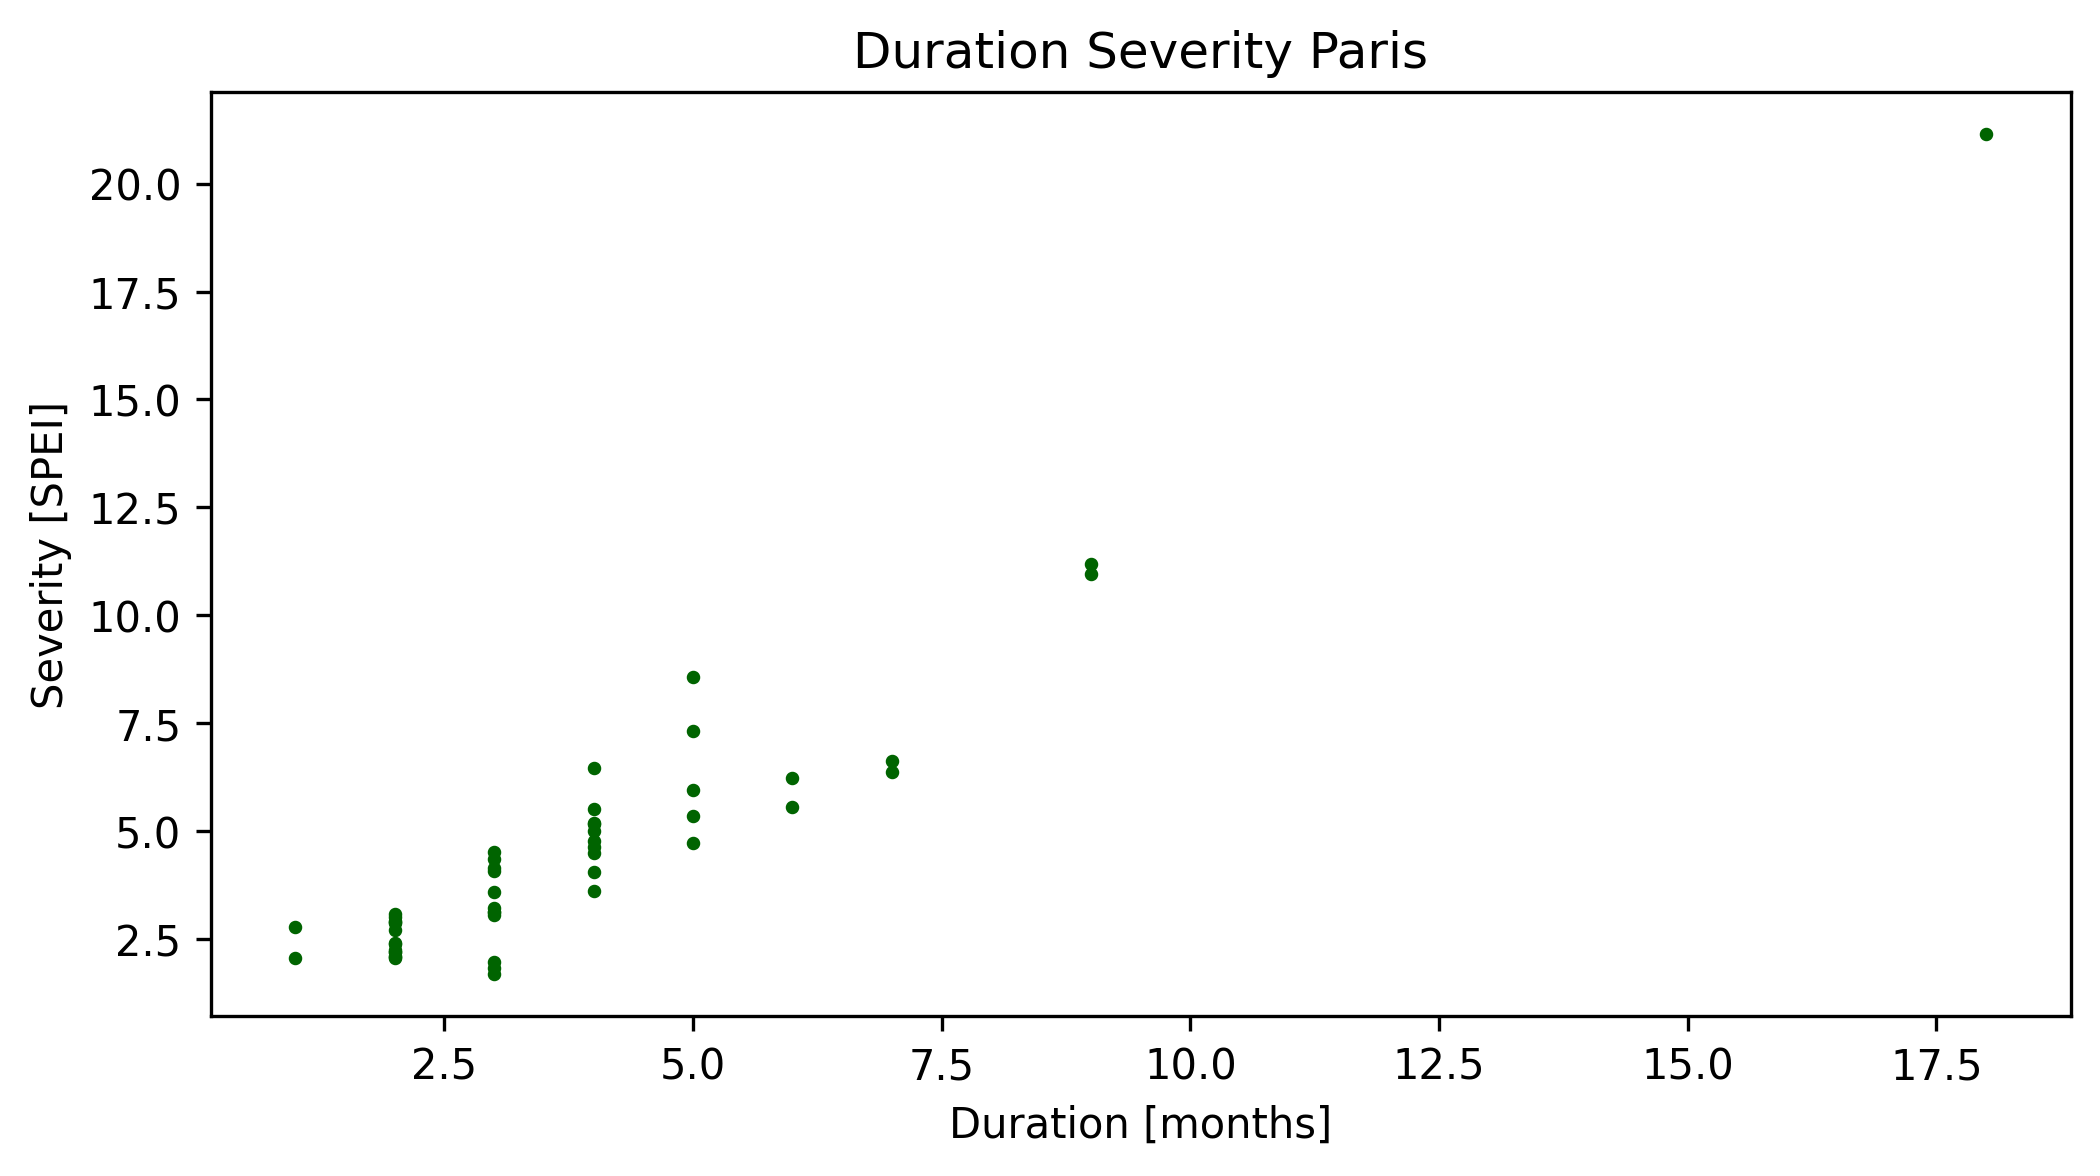

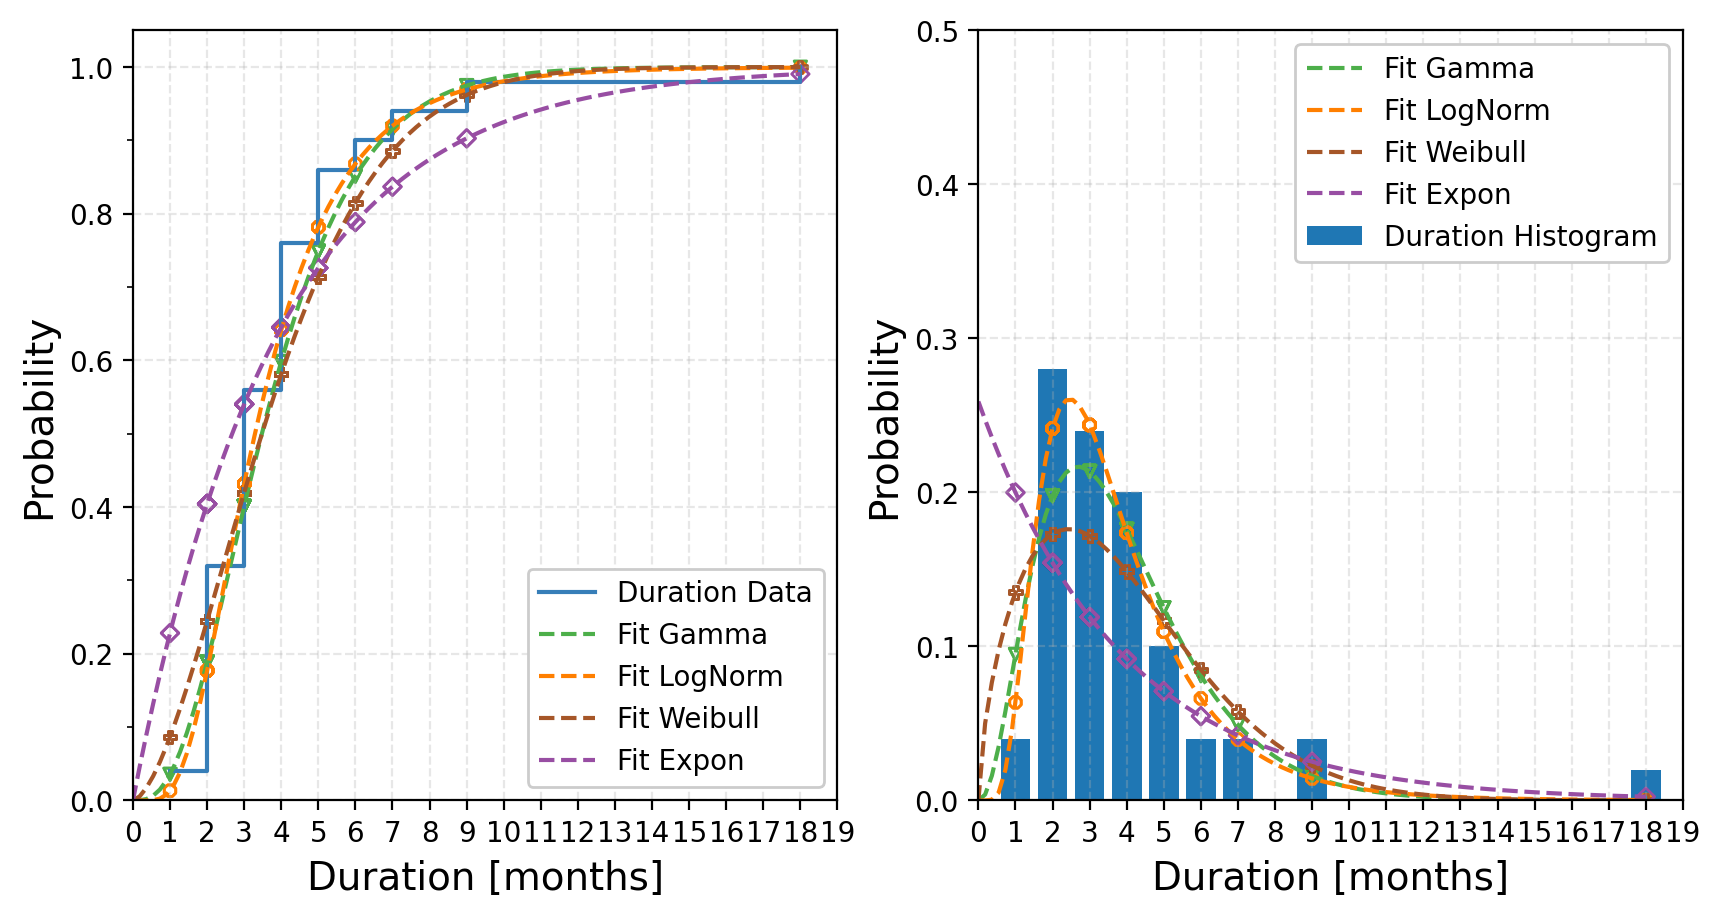

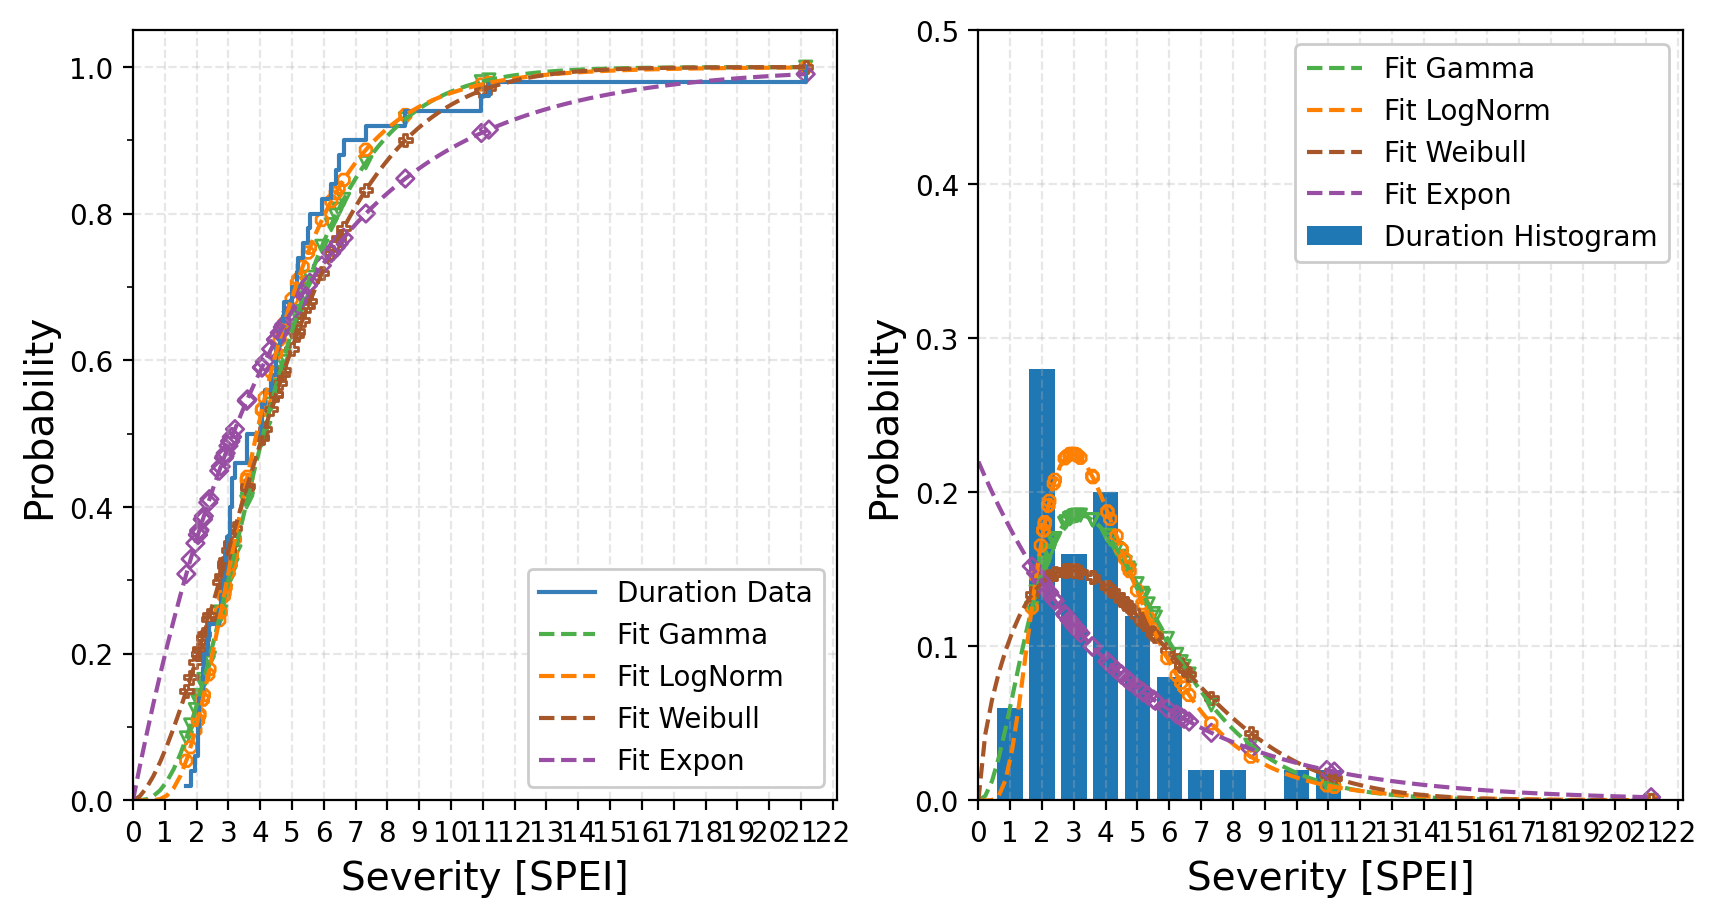

In [30]:
#Define the array for calcultion
#carefull, spei_historic_arr[0] = sf_9 and so on
index = spei_ssp245_arr[1]
index_name = 'spei_histnat_arr[5]'
time_spei_M1_CutCAS = time_spei_ssp245_arr
sf = sf_10


#Set Plots true or false to plot duration-severity pairs and univariate Fitting curves:
plotter=True

#Calculating the Pairs
D_spei_histnat, S_spei_histnat = get_SPEI_Duration_and_Severity_RunTheory(index)

#Plotting the Pairs
if plotter==True:
    fig1, ax1 = plt.subplots(ncols = 1, nrows = 1,figsize=(8,4),dpi=300)
    ax1.scatter(D_spei_histnat,S_spei_histnat,s=5,c="darkgreen")
    ax1.set_xlabel(r'Duration [months]',fontsize='10')
    ax1.set_ylabel(r'Severity [SPEI]',fontsize='10')
    plt.title("Duration Severity Paris")

#Giving important information about the data
print("number of pairs",len(D_spei_histnat))
print("PearsonR Duration and Severity:",stats.pearsonr(D_spei_histnat, S_spei_histnat))

#Creating pd.array      
Duration = pd.Series(D_spei_histnat, name='Duration')
Severity = pd.Series(S_spei_histnat, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
       
#Fitting Duration
x_D = np.linspace(0, D_S_array['Duration'].max(), 100)
#Exponential
expon = stats.expon
param_expon_D = expon.fit(D_S_array['Duration'],floc=0)
cdf_fitted_expon_D = expon.cdf(x_D, *param_expon_D)
pdf_fitted_expon_D = expon.pdf(x_D, *param_expon_D)
fitted_expon_D = sk_uni.expon.fit(D_S_array['Duration'],param_expon_D)
#Gamma
gamma = stats.gamma
param_gamma_D = gamma.fit(D_S_array['Duration'],floc=0)
cdf_fitted_gamma_D = gamma.cdf(x_D, *param_gamma_D)
pdf_fitted_gamma_D = gamma.pdf(x_D, *param_gamma_D)
fitted_gamma_D = sk_uni.gamma.fit(D_S_array['Duration'],param_gamma_D)
#Lognorm
lognorm = stats.lognorm
param_lognorm_D = lognorm.fit(D_S_array['Duration'],floc=0)
cdf_fitted_lognorm_D = lognorm.cdf(x_D, *param_lognorm_D)
pdf_fitted_lognorm_D = lognorm.pdf(x_D, *param_lognorm_D)
fitted_lognorm_D = sk_uni.lognorm.fit(D_S_array['Duration'],param_lognorm_D)
#Weibull
weibull = stats.weibull_min
param_weibull_D = weibull.fit(D_S_array['Duration'],floc=0)
cdf_fitted_weibull_D = weibull.cdf(x_D, *param_weibull_D)
pdf_fitted_weibull_D = weibull.pdf(x_D, *param_weibull_D)
fitted_weibull_D = sk_uni.weibull_min.fit(D_S_array['Duration'],param_weibull_D)
      
#Calculating important metrics for the testing
weights_D = np.ones_like(D_S_array['Duration'])/float(len(D_S_array['Duration']))
bins_D=np.arange(min(D_S_array['Duration']), max(D_S_array['Duration']) + 2, 1)
number_bins_D = len(bins_D)
count_D, bins_count_D = np.histogram(D_S_array['Duration'], bins=bins_D,weights=weights_D)
bins_count_D = bins_count_D[:-1]
cdf_D = np.cumsum(count_D)

#Plotting the Duration fits
if plotter==True:
    fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi = 200)
    ax2[0].step(bins_count_D[:],cdf_D,color='#377eb8',label=r'Duration Data',where='post')
    ax2[0].plot(x_D, cdf_fitted_gamma_D, color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax2[0].scatter(D_S_array['Duration'],gamma.cdf(D_S_array['Duration'], *param_gamma_D),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax2[0].plot(x_D, cdf_fitted_lognorm_D, color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax2[0].scatter(D_S_array['Duration'],lognorm.cdf(D_S_array['Duration'], *param_lognorm_D),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax2[0].plot(x_D, cdf_fitted_weibull_D, color='#a65628',label=r'Fit Weibull',ls='--')
    ax2[0].scatter(D_S_array['Duration'],weibull.cdf(D_S_array['Duration'], *param_weibull_D),s=20,color='#a65628',marker="P",facecolors='none')
    ax2[0].plot(x_D, cdf_fitted_expon_D, color='#984ea3',label=r'Fit Expon',ls='--')
    ax2[0].scatter(D_S_array['Duration'],expon.cdf(D_S_array['Duration'], *param_expon_D),s=20,color='#984ea3',marker="D",facecolors='none')
    ax2[0].set_xlim(0, D_S_array['Duration'].max()+1)
    ax2[0].set_ylim(0,1.05)
    ax2[0].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax2[0].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend0 = ax2[0].legend(loc="lower right",fontsize='10')
    legend0.get_frame().set_alpha(0.5)
    legend0.get_frame().set_alpha(None)
    ax2[0].set_xlabel(r'Duration [months]',fontsize='14')
    ax2[0].set_ylabel(r'Probability',fontsize='14')
    ax2[0].tick_params(axis='both', which='major', labelsize='10')
    ax2[0].grid(True,alpha=0.3,linestyle = 'dashed')
    ax2[1].bar(bins_count_D,count_D,label=r'Duration Histogram')
    ax2[1].plot(x_D, pdf_fitted_gamma_D, color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax2[1].scatter(D_S_array['Duration'],gamma.pdf(D_S_array['Duration'], *param_gamma_D),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax2[1].plot(x_D, pdf_fitted_lognorm_D, color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax2[1].scatter(D_S_array['Duration'],lognorm.pdf(D_S_array['Duration'], *param_lognorm_D),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax2[1].plot(x_D, pdf_fitted_weibull_D, color='#a65628',label=r'Fit Weibull',ls='--')
    ax2[1].scatter(D_S_array['Duration'],weibull.pdf(D_S_array['Duration'], *param_weibull_D),s=20,color='#a65628',marker="P",facecolors='none')
    ax2[1].plot(x_D, pdf_fitted_expon_D, color='#984ea3',label=r'Fit Expon',ls='--')
    ax2[1].scatter(D_S_array['Duration'],expon.pdf(D_S_array['Duration'], *param_expon_D),s=20,color='#984ea3',marker="D",facecolors='none')
    ax2[1].set_xlim(0, D_S_array['Duration'].max()+1)
    ax2[1].set_ylim(0,0.5)
    ax2[1].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax2[1].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend1 = ax2[1].legend(loc="upper right",fontsize='10')
    legend1.get_frame().set_alpha(0.5)
    legend1.get_frame().set_alpha(None)
    ax2[1].set_xlabel(r'Duration [months]',fontsize='14')
    ax2[1].set_ylabel(r'Probability',fontsize='14')
    ax2[1].tick_params(axis='both', which='major', labelsize='10')
    ax2[1].grid(True,alpha=0.3,linestyle = 'dashed')

#Doing the same for Severity fits
x_S = np.linspace(0, D_S_array['Severity'].max(), 100)
#Exponential
expon = stats.expon
param_expon_S = expon.fit(D_S_array['Severity'],floc=0)
cdf_fitted_expon_S = expon.cdf(x_S, *param_expon_S)
fitted_expon_S = sk_uni.expon.fit(D_S_array['Severity'],param_expon_S)
#Gamma
gamma = stats.gamma
param_gamma_S = gamma.fit(D_S_array['Severity'],floc=0)
cdf_fitted_gamma_S = gamma.cdf(x_S, *param_gamma_S)
fitted_gamma_S = sk_uni.gamma.fit(D_S_array['Severity'],param_gamma_S)
#Lognorm
lognorm = stats.lognorm
param_lognorm_S = lognorm.fit(D_S_array['Severity'],floc=0)
cdf_fitted_lognorm_S = lognorm.cdf(x_S, *param_lognorm_S)
fitted_lognorm_S = sk_uni.lognorm.fit(D_S_array['Severity'],param_lognorm_S)
#Weibull
weibull = stats.weibull_min
param_weibull_S = weibull.fit(D_S_array['Severity'],floc=0)
cdf_fitted_weibull_S = weibull.cdf(x_S, *param_weibull_S)
fitted_weibull_S = sk_uni.weibull_min.fit(D_S_array['Severity'],param_weibull_S)
      
#The next step only works if there are no doubles, check if there are doubles:
if len(D_S_array['Severity']) != len(np.unique(D_S_array['Severity'])):
    print("Doubles!!!!!")
    sys.exit("Error message")

#Get CDF
weights_S = np.ones_like(D_S_array['Severity'])/float(len(D_S_array['Severity']))
cdf_histogram_S = np.zeros(len(D_S_array['Severity'])+1)
for i in np.arange(1,len(D_S_array['Severity']),1):
    cdf_histogram_S[i] = cdf_histogram_S[i-1] + weights_S[0]
cdf_histogram_S[-1] = cdf_histogram_S[-2] + weights_S[0]
cdf_histogram_S_xval = np.append(np.array([0]),np.unique(D_S_array['Severity']))
Severity_unique = np.unique(D_S_array['Severity'])

#Get PDF
bins_S=np.arange(np.ceil(min(D_S_array['Severity'])), np.ceil(max(D_S_array['Severity'])) + 2, 1)
number_bins_S = len(bins_D)
count_S, bins_count_S = np.histogram(D_S_array['Severity'], bins=bins_D,weights=weights_S)
bins_count_S = bins_count_S[:-1]

if plotter==True:
    fig3, ax3 = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi = 200)
    ax3[0].step(cdf_histogram_S_xval[1:],cdf_histogram_S[1:],color='#377eb8',label=r'Duration Data',where='post')
    ax3[0].plot(x_S, cdf_fitted_gamma_S, color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax3[0].scatter(D_S_array['Severity'],gamma.cdf(D_S_array['Severity'], *param_gamma_S),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax3[0].plot(x_S, cdf_fitted_lognorm_S, color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax3[0].scatter(D_S_array['Severity'],lognorm.cdf(D_S_array['Severity'], *param_lognorm_S),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax3[0].plot(x_S, cdf_fitted_weibull_S, color='#a65628',label=r'Fit Weibull',ls='--')
    ax3[0].scatter(D_S_array['Severity'],weibull.cdf(D_S_array['Severity'], *param_weibull_S),s=20,color='#a65628',marker="P",facecolors='none')
    ax3[0].plot(x_S, cdf_fitted_expon_S, color='#984ea3',label=r'Fit Expon',ls='--')
    ax3[0].scatter(D_S_array['Severity'],expon.cdf(D_S_array['Severity'], *param_expon_S),s=20,color='#984ea3',marker="D",facecolors='none')
    ax3[0].set_xlim(0, D_S_array['Severity'].max()+1)
    ax3[0].set_ylim(0,1.05)
    ax3[0].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax3[0].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend0 = ax3[0].legend(loc="lower right",fontsize='10')
    legend0.get_frame().set_alpha(0.5)
    legend0.get_frame().set_alpha(None)
    ax3[0].set_xlabel(r'Severity [SPEI]',fontsize='14')
    ax3[0].set_ylabel(r'Probability',fontsize='14')
    ax3[0].tick_params(axis='both', which='major', labelsize='10')
    ax3[0].grid(True,alpha=0.3,linestyle = 'dashed')
    ax3[1].bar(bins_count_S,count_S,label=r'Duration Histogram')
    ax3[1].plot(x_S, gamma.pdf(x_S, *param_gamma_S), color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax3[1].scatter(D_S_array['Severity'],gamma.pdf(D_S_array['Severity'], *param_gamma_S),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax3[1].plot(x_S, lognorm.pdf(x_S, *param_lognorm_S), color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax3[1].scatter(D_S_array['Severity'],lognorm.pdf(D_S_array['Severity'], *param_lognorm_S),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax3[1].plot(x_S, weibull.pdf(x_S, *param_weibull_S), color='#a65628',label=r'Fit Weibull',ls='--')
    ax3[1].scatter(D_S_array['Severity'],weibull.pdf(D_S_array['Severity'], *param_weibull_S),s=20,color='#a65628',marker="P",facecolors='none')
    ax3[1].plot(x_S, expon.pdf(x_S, *param_expon_S), color='#984ea3',label=r'Fit Expon',ls='--')
    ax3[1].scatter(D_S_array['Severity'],expon.pdf(D_S_array['Severity'], *param_expon_S),s=20,color='#984ea3',marker="D",facecolors='none')
    ax3[1].set_xlim(0, D_S_array['Severity'].max()+1)
    ax3[1].set_ylim(0,0.5)
    ax3[1].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax3[1].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend1 = ax3[1].legend(loc="upper right",fontsize='10')
    legend1.get_frame().set_alpha(0.5)
    legend1.get_frame().set_alpha(None)
    ax3[1].set_xlabel(r'Severity [SPEI]',fontsize='14')
    ax3[1].set_ylabel(r'Probability',fontsize='14')
    ax3[1].tick_params(axis='both', which='major', labelsize='10')
    ax3[1].grid(True,alpha=0.3,linestyle = 'dashed')

#Creating pd.array for Testing Duration Fits
print("Duration Fit:")
dis=np.array(['Expon','Gamma','LogNorm','Weibull'])
AIC_norm = np.array([aic(len(param_expon_D)-1,expon.logpdf(D_S_array['Duration'], *param_expon_D)),
                    aic(len(param_gamma_D)-1,gamma.logpdf(D_S_array['Duration'], *param_gamma_D)),
                    aic(len(param_lognorm_D)-1,lognorm.logpdf(D_S_array['Duration'], *param_lognorm_D)),
                    aic(len(param_weibull_D)-1,weibull.logpdf(D_S_array['Duration'], *param_weibull_D))])
AIC_adap = np.array([aic_2(len(param_expon_D)-1,expon.cdf(D_S_array['Duration'],*param_expon_D),cdf_D[D_S_array['Duration']-1]),
                       aic_2(len(param_gamma_D)-1,gamma.cdf(D_S_array['Duration'],*param_gamma_D),cdf_D[D_S_array['Duration']-1]),
                       aic_2(len(param_lognorm_D)-1,lognorm.cdf(D_S_array['Duration'],*param_lognorm_D),cdf_D[D_S_array['Duration']-1]),
                       aic_2(len(param_weibull_D)-1,weibull.cdf(D_S_array['Duration'],*param_weibull_D),cdf_D[D_S_array['Duration']-1])])
MSE_adap = np.array([mse_2(len(param_expon_D)-1,expon.cdf(D_S_array['Duration'],*param_expon_D),cdf_D[D_S_array['Duration']-1]),
                       mse_2(len(param_gamma_D)-1,gamma.cdf(D_S_array['Duration'],*param_gamma_D),cdf_D[D_S_array['Duration']-1]),
                       mse_2(len(param_lognorm_D)-1,lognorm.cdf(D_S_array['Duration'],*param_lognorm_D),cdf_D[D_S_array['Duration']-1]),
                       mse_2(len(param_weibull_D)-1,weibull.cdf(D_S_array['Duration'],*param_weibull_D),cdf_D[D_S_array['Duration']-1])])
KS_p = np.array([stats.kstest(D_S_array['Duration'],stats.expon.cdf,args=param_expon_D).pvalue,
                stats.kstest(D_S_array['Duration'],stats.gamma.cdf,args=param_gamma_D).pvalue,
                stats.kstest(D_S_array['Duration'],stats.lognorm.cdf,args=param_lognorm_D).pvalue,
                stats.kstest(D_S_array['Duration'],stats.weibull_min.cdf,args=param_weibull_D).pvalue])
KS_dist = np.array([stats.kstest(D_S_array['Duration'],stats.expon.cdf,args=param_expon_D).statistic,
                stats.kstest(D_S_array['Duration'],stats.gamma.cdf,args=param_gamma_D).statistic,
                stats.kstest(D_S_array['Duration'],stats.lognorm.cdf,args=param_lognorm_D).statistic,
                stats.kstest(D_S_array['Duration'],stats.weibull_min.cdf,args=param_weibull_D).statistic])
Distribution = pd.Series(dis, name='Distribution')
AIC_normal = pd.Series(AIC_norm, name='AIC_normal')
AIC_adapted = pd.Series(AIC_adap, name='AIC_adapted')
MSE_adapted = pd.Series(MSE_adap, name='MSE_adapted')
KS_pValue = pd.Series(KS_p, name='KS_pValue')
KS_Distance = pd.Series(KS_dist, name='KS_Distance')
Duration_fit = pd.concat([Distribution,AIC_normal,AIC_adapted,MSE_adapted,KS_pValue,KS_Distance], axis=1)
display(Duration_fit)
print("-----> best fit according to AIC_normal:", Distribution[np.argmin(AIC_normal)])

#Creating pd.array for Testing Severity Fits
print("Severity Fit:")
dis_S=np.array(['Expon','Gamma','LogNorm','Weibull'])
AIC_norm_S = np.array([aic(len(param_expon_S)-1,expon.logpdf(D_S_array['Severity'], *param_expon_S)),
                    aic(len(param_gamma_S)-1,gamma.logpdf(D_S_array['Severity'], *param_gamma_S)),
                    aic(len(param_lognorm_S)-1,lognorm.logpdf(D_S_array['Severity'], *param_lognorm_S)),
                    aic(len(param_weibull_S)-1,weibull.logpdf(D_S_array['Severity'], *param_weibull_S))])
AIC_adap_S = np.array([aic_2(len(param_expon_S)-1,expon.cdf(np.sort(D_S_array['Severity']),*param_expon_S),cdf_histogram_S[1:]),
                       aic_2(len(param_gamma_S)-1,gamma.cdf(np.sort(D_S_array['Severity']),*param_gamma_S),cdf_histogram_S[1:]),
                       aic_2(len(param_lognorm_S)-1,lognorm.cdf(np.sort(D_S_array['Severity']),*param_lognorm_S),cdf_histogram_S[1:]),
                       aic_2(len(param_weibull_S)-1,weibull.cdf(np.sort(D_S_array['Severity']),*param_weibull_S),cdf_histogram_S[1:])])
MSE_adap_S = np.array([mse_2(len(param_expon_S)-1,expon.cdf(np.sort(D_S_array['Severity']),*param_expon_S),cdf_histogram_S[1:]),
                    mse_2(len(param_gamma_S)-1,gamma.cdf(np.sort(D_S_array['Severity']),*param_gamma_S),cdf_histogram_S[1:]),
                    mse_2(len(param_lognorm_S)-1,lognorm.cdf(np.sort(D_S_array['Severity']),*param_lognorm_S),cdf_histogram_S[1:]),
                    mse_2(len(param_weibull_S)-1,weibull.cdf(np.sort(D_S_array['Severity']),*param_weibull_S),cdf_histogram_S[1:])])
KS_p_S = np.array([stats.kstest(D_S_array['Severity'],stats.expon.cdf,args=param_expon_S).pvalue,
                stats.kstest(D_S_array['Severity'],stats.gamma.cdf,args=param_gamma_S).pvalue,
                stats.kstest(D_S_array['Severity'],stats.lognorm.cdf,args=param_lognorm_S).pvalue,
                stats.kstest(D_S_array['Severity'],stats.weibull_min.cdf,args=param_weibull_S).pvalue])
KS_dist_S = np.array([stats.kstest(D_S_array['Severity'],stats.expon.cdf,args=param_expon_S).statistic,
                stats.kstest(D_S_array['Severity'],stats.gamma.cdf,args=param_gamma_S).statistic,
                stats.kstest(D_S_array['Severity'],stats.lognorm.cdf,args=param_lognorm_S).statistic,
                stats.kstest(D_S_array['Severity'],stats.weibull_min.cdf,args=param_weibull_S).statistic])
Distribution_S = pd.Series(dis_S, name='Distribution')
AIC_normal_S = pd.Series(AIC_norm_S, name='AIC_normal')
AIC_adapted_S = pd.Series(AIC_adap_S, name='AIC_adapted')
MSE_adapted_S = pd.Series(MSE_adap_S, name='MSE_adapted')
KS_pValue_S = pd.Series(KS_p_S, name='KS_pValue')
KS_Distance_S = pd.Series(KS_dist_S, name='KS_Distance')
Severity_fit = pd.concat([Distribution_S,AIC_normal_S,AIC_adapted_S,MSE_adapted_S,KS_pValue_S,KS_Distance_S], axis=1)
display(Severity_fit)
print("-----> best fit according to AIC_normal:", Distribution_S[np.argmin(AIC_normal_S)])

/rds/general/user/nmerz/home/.conda/envs/thesis/lib/python3.9/site-packages/sklarpy/multivariate/_distributions/_archimedean.py:478: RuntimeWarning: overflow encountered in power
  * np.power(t, theta_inv - K + j) * prod
/rds/general/user/nmerz/home/.conda/envs/thesis/lib/python3.9/site-packages/sklarpy/multivariate/_distributions/_archimedean.py:477: RuntimeWarning: overflow encountered in multiply
  DK_psi -= self._DK_psi(t=t, params=params, K=j) \


GUMBLE: Upper Tail dependece lambda: 0.7715248469415534
GUMBLE: CDF Estimator fit: 0.7721068483562509
GUMBLE: Kendal Tau rank correlation: 0.703131321723505
FRANK: CDF Estimator fit: 0.7166886628681369
CLAYTON: CDF Estimator fit: 0.6940469793637454


/var/tmp/pbs.9627857.pbs/ipykernel_1420365/4035745827.py:129: RuntimeWarning: divide by zero encountered in log
  p = (v - np.exp(-(((-np.log(u))**copula_para.theta)+(-np.log(v))**copula_para.theta)**(1/copula_para.theta)))/(1-u)
/var/tmp/pbs.9627857.pbs/ipykernel_1420365/4035745827.py:139: RuntimeWarning: divide by zero encountered in log
  p = (u - np.exp(-(((-np.log(u))**copula_para.theta)+(-np.log(v))**copula_para.theta)**(1/copula_para.theta)))/(1-v)


<GeoAxes: title={'center': 'Drought Atlast, Severity (=3.164) for return period = 100 and duration = 1'}, xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>

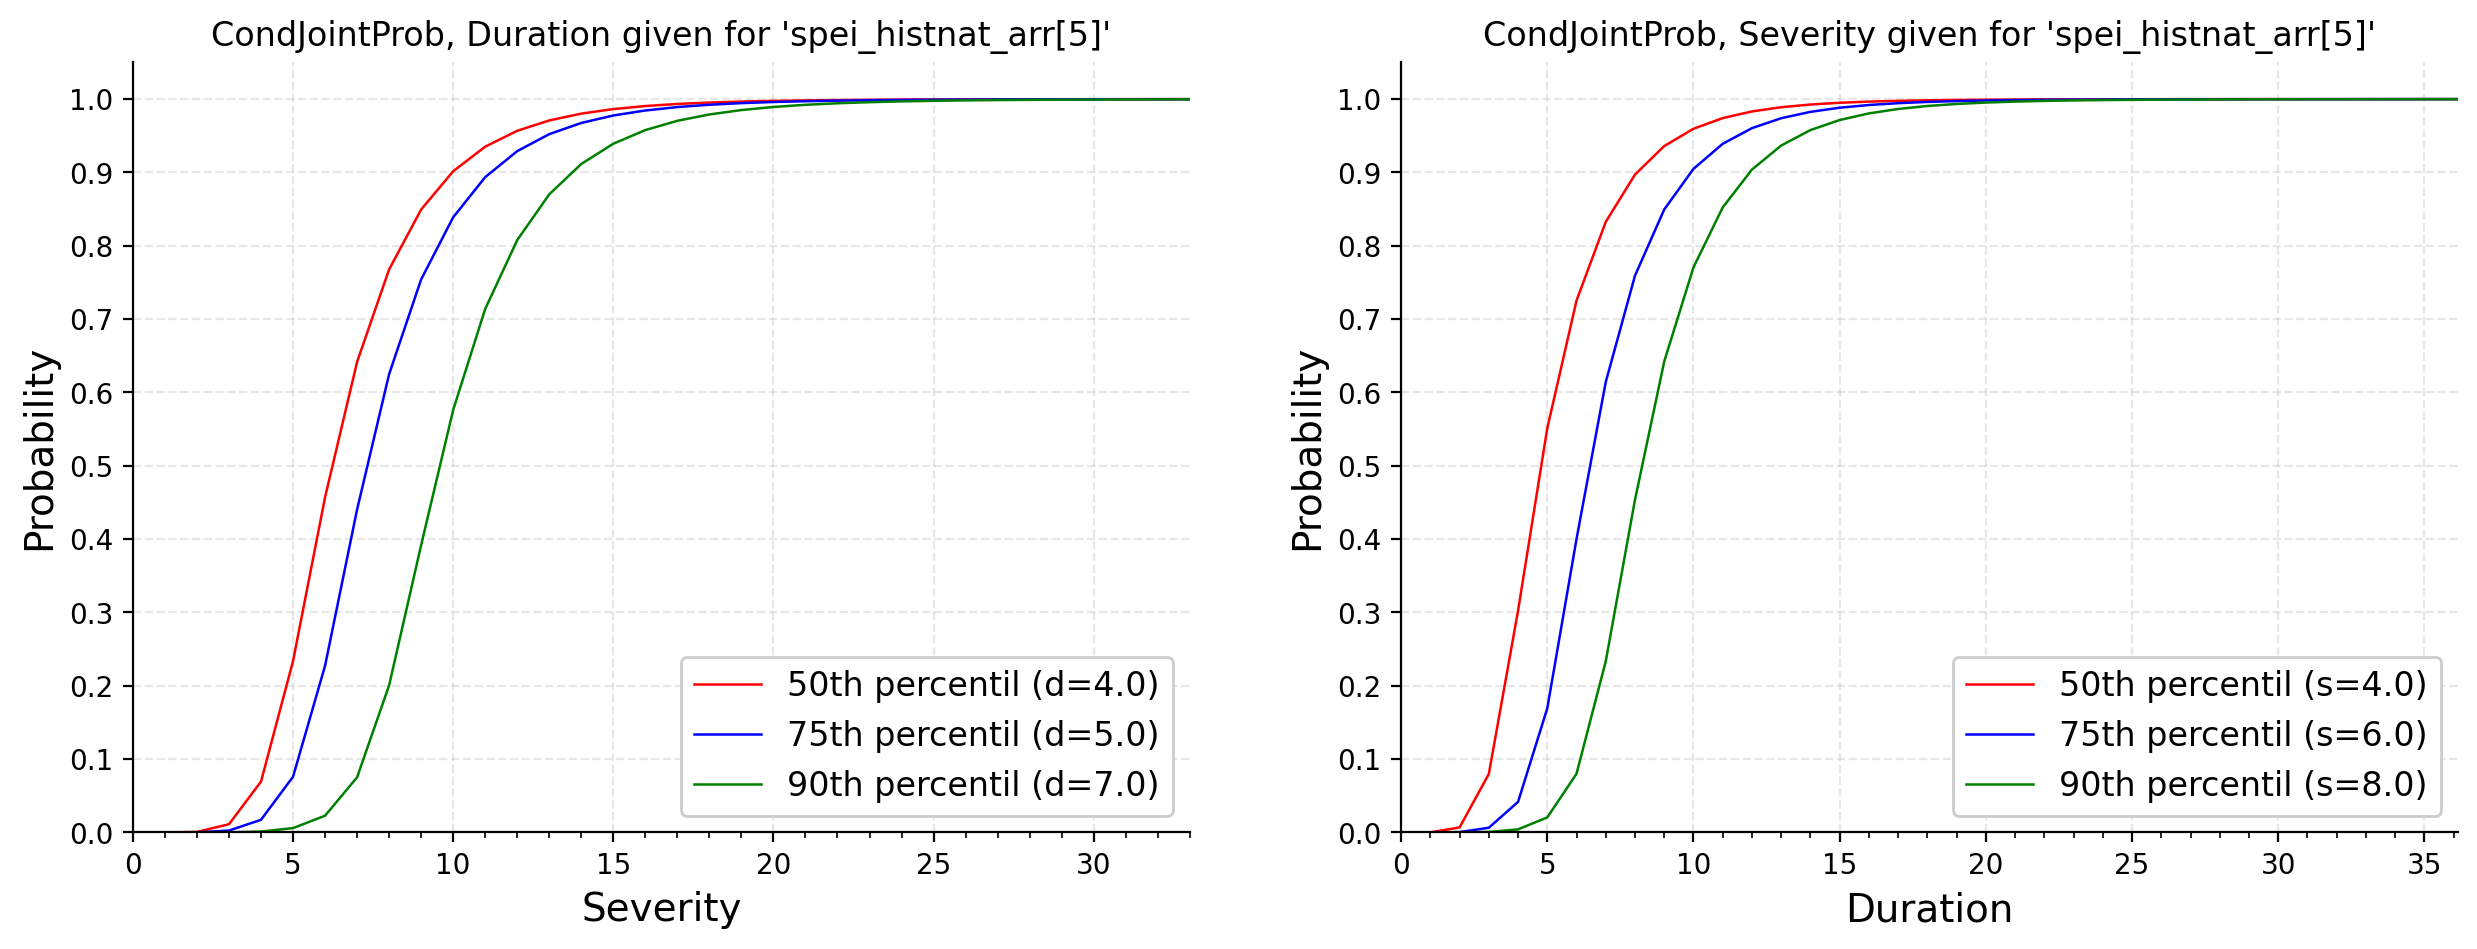

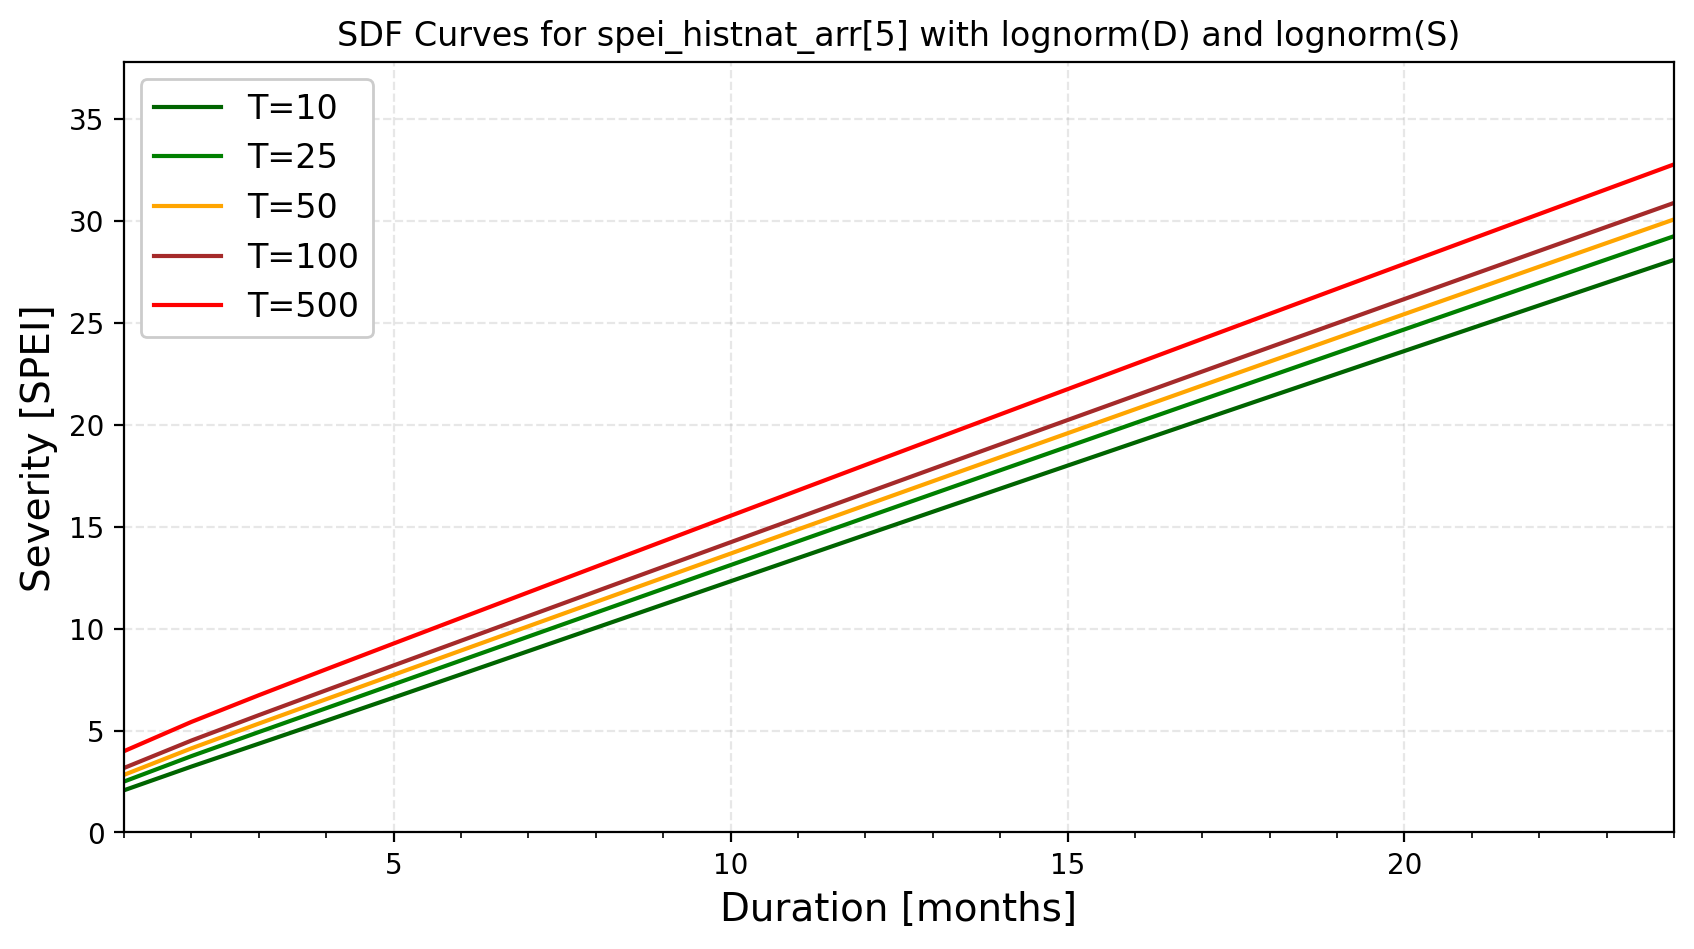

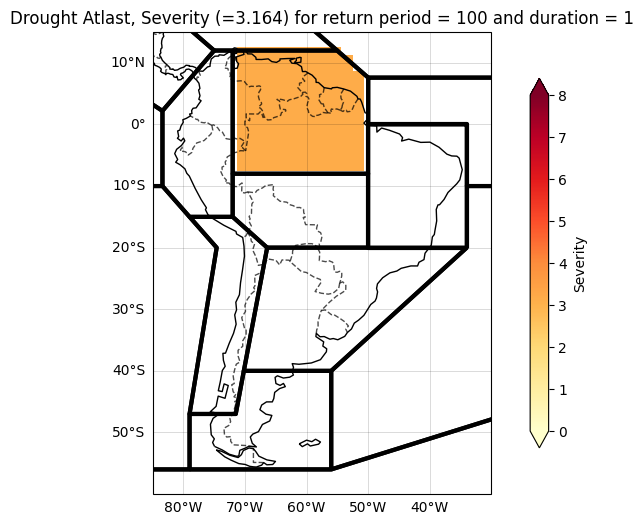

In [31]:
#define univariate Distribution
marg_dist_D_M1_histnat = fitted_lognorm_D
marg_dist_S_M1_histnat = fitted_lognorm_S

marg_dist_histnat={0:marg_dist_D_M1_histnat,1:marg_dist_S_M1_histnat}

plotter_CondJointDist=True

#Calculate Copulas
fitted_copula_gumble = gumbel_copula.fit(
    data=D_S_array, method='mle',
    univariate_fitter_options={'significant': False}, show_progress=False,mdists=marg_dist_histnat)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fitted_copula_frank = frank_copula.fit(
        data=D_S_array, method='mle',
        univariate_fitter_options={'significant': False}, show_progress=False,mdists=marg_dist_histnat)
    fitted_copula_clayton = clayton_copula.fit(
        data=D_S_array, method='mle',
        univariate_fitter_options={'significant': False}, show_progress=False,mdists=marg_dist_histnat)

#Calculate Fitting test
lambda_up = 2-2**(1/fitted_copula_gumble.copula_params.to_dict["theta"])
print("GUMBLE: Upper Tail dependece lambda:",lambda_up)
print("GUMBLE: CDF Estimator fit:",cdf_estimator_test(fitted_copula_gumble,100))
kendal_tau = 1-1/fitted_copula_gumble.copula_params.to_dict["theta"]
print("GUMBLE: Kendal Tau rank correlation:",kendal_tau)
print("FRANK: CDF Estimator fit:",cdf_estimator_test(fitted_copula_frank,100))
print("CLAYTON: CDF Estimator fit:",cdf_estimator_test(fitted_copula_clayton,100))

#Calculate SDF-Curves!!!!!!!!!!!!!!
#Calculated Return Periods
return_T = np.array([10,25,50,100,500])
#Length of array
n = len(D_S_array['Severity'])
#Timeperiod under consideration
diff = time_spei_M1_CutCAS[-1] - time_spei_M1_CutCAS[0] #!!!!CAREFULL HERE!!!!!
N=diff.astype('timedelta64[Y]').astype('int')+1 #As it round offs but actually it should round up if it 29.9 years
#Define till which month should be plotted -1
dur_treshold = max(D_S_array['Duration'])+7
#Set up array to safe results
sev_M1_histnat = np.zeros((len(return_T), len(np.arange(1,dur_treshold,1))))
for T in np.arange(0,len(return_T),1):
    return_Time = return_T[T]
    #calc return
    r = 1 - N / (n * return_Time)
    #give Duration range
    dur_M1_histnat = np.arange(1,dur_treshold,1)
    #calc fitted univariate duration curve
    u1 = fitted_copula_gumble.mdists[0].cdf(dur_M1_histnat)
    #load gumble fitting parameters !!!! Change here if other Copula is used but also equation below
    copula_para = fitted_copula_gumble.copula_params
    #Create Temporay value for severity
    v = np.zeros(len(u1))
    #Solve conditional gumble equation for all duration values for severity !!!! Change here if other Copula is used
    for j in np.arange(0,len(u1),1):
        def cond_gumbel(x):
            D_cdf = u1[j]
            return 1/D_cdf * np.exp(-(((-np.log(D_cdf))**copula_para.theta)+(-np.log(x))**copula_para.theta)**(1/copula_para.theta))*(1+((-np.log(x))/(-np.log(D_cdf)))**copula_para.theta)**(-1+(1/copula_para.theta))-r
        #V = fsolve(cond_gumbel,u1[j]) -> uses other algorithm than Matlab...
        V_root = optimize.root(cond_gumbel,u1[j],method='lm').x
        v[j] = V_root[0]
    #get the final severity values through the inverse cdf function
    sev_M1_histnat[T] = fitted_copula_gumble.mdists[1].ppf(v)


#Plot Conditional Joint Probability:
if plotter_CondJointDist==True:
    t_50_1=0
    t_75_1=0
    t_90_1=0
    t_50_2=0
    t_75_2=0
    t_90_2=0
    for t in np.arange(1,500,1):
        t=float(t)
        if t_50_1==0:
            if fitted_copula_gumble.mdists[0].cdf(t)[0]>=0.5:
                d_50percentil = t
                t_50_1=1
        if t_50_1==1 and t_75_1==0:
            if fitted_copula_gumble.mdists[0].cdf(t)[0]>=0.75:
                d_75percentil = t
                t_75_1=1
        if t_75_1==1 and t_90_1==0:
            if fitted_copula_gumble.mdists[0].cdf(t)[0]>=0.90:
                d_90percentil = t
                t_90_1=1
                break
    for i in np.arange(1,500,1):
        i=float(i)
        if t_50_2==0:
            if fitted_copula_gumble.mdists[1].cdf(i)[0]>=0.5:
                s_50percentil = i
                t_50_2=1
        if t_50_2==1 and t_75_2==0:
            if fitted_copula_gumble.mdists[1].cdf(i)[0]>=0.75:
                s_75percentil = i
                t_75_2=1
        if t_75_2==1 and t_90_2==0:
            if fitted_copula_gumble.mdists[1].cdf(i)[0]>=0.90:
                s_90percentil = i
                t_90_2=1
                break
    s_p_50percentil, p_50percentil_s = S_cond_joint_pdf_GH(d_50percentil,length=max(D_S_array['Duration'])+15)
    s_p_75percentil, p_75percentil_s = S_cond_joint_pdf_GH(d_75percentil,length=max(D_S_array['Duration'])+15)
    s_p_90percentil, p_90percentil_s = S_cond_joint_pdf_GH(d_90percentil,length=max(D_S_array['Duration'])+15)
    d_p_50percentil, p_50percentil_d = D_cond_joint_pdf_GH(s_50percentil,length=max(D_S_array['Severity'])+15)
    d_p_75percentil, p_75percentil_d = D_cond_joint_pdf_GH(s_75percentil,length=max(D_S_array['Severity'])+15)
    d_p_90percentil, p_90percentil_d = D_cond_joint_pdf_GH(s_90percentil,length=max(D_S_array['Severity'])+15)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5),dpi = 200)
    label_50_s = "50th percentil (d={})".format(d_50percentil)
    ax[0].plot(s_p_50percentil, p_50percentil_s,label=label_50_s,c='red',linewidth=0.9)
    label_75_s = "75th percentil (d={})".format(d_75percentil)
    ax[0].plot(s_p_75percentil, p_75percentil_s,label=label_75_s,c='blue',linewidth=0.9)
    label_90_s = "90th percentil (d={})".format(d_90percentil)
    ax[0].plot(s_p_90percentil, p_90percentil_s,label=label_90_s,c='green',linewidth=0.9)
    ax[0].set_xlim(0,max(D_S_array['Duration'])+15)
    ax[0].set_ylim(0,1.05)
    ax[0].xaxis.set_major_locator(MultipleLocator(5))# defines setting of the small ticks
    ax[0].xaxis.set_minor_locator(MultipleLocator(1))# defines setting of the small ticks
    ax[0].yaxis.set_major_locator(MultipleLocator(.1))# defines setting of the small ticks
    ax[0].set_xlabel(r'Severity',fontsize='14')
    ax[0].set_ylabel(r'Probability',fontsize='14')
    ax[0].tick_params(axis='both', which='major', labelsize='10')
    ax[0].spines[['top', 'right']].set_visible(False)
    title_str_s = "CondJointProb, Duration given for '{}'".format(index_name)
    ax[0].set_title(title_str_s)
    legend0 = ax[0].legend(loc="lower right",fontsize='12')
    legend0.get_frame().set_alpha(0.5)
    legend0.get_frame().set_alpha(None)
    ax[0].grid(True,alpha=0.3,linestyle = 'dashed')
    
    label_50_d = "50th percentil (s={})".format(s_50percentil)
    ax[1].plot(d_p_50percentil, p_50percentil_d,label=label_50_d,c='red',linewidth=0.9)
    label_75_d = "75th percentil (s={})".format(s_75percentil)
    ax[1].plot(d_p_75percentil, p_75percentil_d,label=label_75_d,c='blue',linewidth=0.9)
    label_90_d = "90th percentil (s={})".format(s_90percentil)
    ax[1].plot(d_p_90percentil, p_90percentil_d,label=label_90_d,c='green',linewidth=0.9)
    ax[1].set_xlim(0,max(D_S_array['Severity'])+15)
    ax[1].set_ylim(0,1.05)
    ax[1].xaxis.set_major_locator(MultipleLocator(5))# defines setting of the small ticks
    ax[1].xaxis.set_minor_locator(MultipleLocator(1))# defines setting of the small ticks
    ax[1].yaxis.set_major_locator(MultipleLocator(.1))# defines setting of the small ticks
    ax[1].set_xlabel(r'Duration',fontsize='14')
    ax[1].set_ylabel(r'Probability',fontsize='14')
    ax[1].tick_params(axis='both', which='major', labelsize='10')
    ax[1].spines[['top', 'right']].set_visible(False)
    title_str_d = "CondJointProb, Severity given for '{}'".format(index_name)
    ax[1].set_title(title_str_d)
    legend1 = ax[1].legend(loc="lower right",fontsize='12')
    legend1.get_frame().set_alpha(0.5)
    legend1.get_frame().set_alpha(None)
    ax[1].grid(True,alpha=0.3,linestyle = 'dashed')

#Plot Results
fig, ax = plt.subplots(figsize=(10,5),dpi = 200)
ax.plot(dur_M1_histnat, sev_M1_histnat[0], color='darkgreen',label=r'T=10')
ax.plot(dur_M1_histnat, sev_M1_histnat[1], color='g',label=r'T=25')
ax.plot(dur_M1_histnat, sev_M1_histnat[2], color='orange',label=r'T=50')
ax.plot(dur_M1_histnat, sev_M1_histnat[3], color='brown',label=r'T=100')
ax.plot(dur_M1_histnat, sev_M1_histnat[4], color='red',label=r'T=500')
ax.set_xlim(1, dur_treshold-1)
ax.set_ylim(0,sev_M1_histnat[4][-1]+5)
#ax.axvline(max(D_S_array['Duration']),c="black", ls="dashed")
#ax.axhline(max(D_S_array['Severity']),c="black", ls="dashed")
ax.xaxis.set_minor_locator(MultipleLocator(1))# defines setting of the small ticks
#ax.yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
legend = plt.legend(loc="upper left",fontsize='12')
legend.get_frame().set_alpha(0.5)
legend.get_frame().set_alpha(None)
title_str = "SDF Curves for {} with {}(D) and {}(S)".format(index_name,marg_dist_D_M1_histnat.name,marg_dist_S_M1_histnat.name)
ax.set_title(title_str)
ax.set_xlabel(r'Duration [months]',fontsize='14')
ax.set_ylabel(r'Severity [SPEI]',fontsize='14')
ax.tick_params(axis='both', which='major', labelsize='10')
ax.grid(True,alpha=0.3,linestyle = 'dashed')

#Calculate Drought Atlas
DA_return_T = 100
DA_duration = 1
DA_r = 1 - N / (n * DA_return_T)
DA_u1 = fitted_copula_gumble.mdists[0].cdf(DA_duration)
def cond_gumbel(x):
    D_cdf = DA_u1
    return 1/D_cdf * np.exp(-(((-np.log(D_cdf))**copula_para.theta)+(-np.log(x))**copula_para.theta)**(1/copula_para.theta))*(1+((-np.log(x))/(-np.log(D_cdf)))**copula_para.theta)**(-1+(1/copula_para.theta))-DA_r
V_root = optimize.root(cond_gumbel,DA_u1,method='lm').x
v = V_root[0]
sev_DA = fitted_copula_gumble.mdists[1].ppf(v)
rm = regionmask.mask_3D_geopandas(sf, load_long_lat.lon, load_long_lat.lat).squeeze(drop = True)
sev_DA_nc = sev_DA_nc.where(~rm.squeeze(drop=True), other=sev_DA)
#sev_DA_nc_1 = spei_M1_raw
#rm = regionmask.mask_3D_geopandas(sf, spei_M1.lon, spei_M1.lat).squeeze(drop = True)
#sev_DA_nc_2 = sev_DA_nc_1.assign(sev_T100_d1=spei_M1_raw.spei*0+sev_DA)
#sev_DA_nc_3 = sev_DA_nc_2.where(rm)
#sev_DA_nc = sev_DA_nc_3.sev_T100_d1.mean(dim="time")
#sev_DA_nc = sev_DA_nc.where(rm).sev_T100_d1 = sev_DA
fig3, ax3 = plt.subplots(ncols = 1, nrows = 1, figsize = (10,6), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
elev_kwargs = {"cmap" : "YlOrRd",
               "vmin" : 0, 
               "vmax" : 8}    # aim to keep 1:4 ratio to change from blue to green at zero
sev_DA_nc.sev_T100_d1.plot(ax = ax3, **elev_kwargs, cbar_kwargs={"label": "Severity",'orientation':'vertical','shrink':0.8},robust=False,extend='both')
glt = ax3.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', alpha=0.2, draw_labels=True)
glt.top_labels = False
glt.right_labels = False
ax3.coastlines()
ax3.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
ax3.set_xlim([-85,-30])
ax3.set_ylim([-60,15])
title_str_DA = "Drought Atlast, Severity (={}) for return period = {} and duration = {}".format(np.round(sev_DA[0],3),DA_return_T,DA_duration)
ax3.set_title(title_str_DA)
sf_all.boundary.plot(ax = ax3, lw = 3, color = "black")